# **Wildfire Size Prediction Project**

## Introduction

### Overview

   Wildfires are increasingly intense natural events that often result in significant damage to many communities and effective wildfire management is becoming more challenging due to extreme weather conditions and limited resources. Classifying and predicting wildfire behavior would optimize wildfire management policy and minimize the losses attributed to these increasingly intense ecological events.
   
   The Government of Alberta (GOA) maintains historical data sets of all wildfire incidents from 1961 to 2018, with 38 fields such as GPS coordinates, total area burned, fire start date, and initial suppression resources. The most recent data set contains data on over 18,000 wildfires between 2006 and 2018. I chose this data set as I previously worked as wildland firefighter in Northern Alberta and want to study the behavior of wildfires and the effectiveness of wildfire management strategy. These data sets are available on the [provincal website](https://wildfire.alberta.ca/resources/historical-data/default.aspx).
   
   Wildfires are defined as fires that have a point of origin within the provincial Forest Protected Area (FPA). They are detected by various groups such as fire tower lookout observers, aircraft patrols, and the general public. About 80% of fires are discovered by the lookout observers and the public, while the remaining 20% is typically discovered by air patrols. Early detection of fires is critical to the successful management of the forest resources throughout the province of Alberta.
   
   Once a fire is detected, the closest fire center is notified, and initial action resources are mobilized. The GOA minimizes the response time through strategic placement of firefighting crews and air tankers based on the expected risk on a given day. This response time is tracked and used as a metric of the effectiveness of the initial action and is included in the provided data sets.
   
   Wildfires exits in one of four states: **Out-of-control (OC)**, **Being-Held (BH)**, **Under-Control (UC)**, and **Extinguished (EX)**. All detected wildfires begin in the out-of-control state and can stay there even after supression resources are deployed. The incident commander, who manages the suppression efforts of the fire, is responsible to update the size and status of a wildfire. He/She does this typically by walking the perimeter of the fire setting GPS waypoints along the perimeter. To move from UC to BH, a wildfire must be momentarily contained and no longer growing in size. A fire in the UC state means that there are no observable flames and the fire is completely contained, depsite hot spots existing in the burned area. An extinguished fire is completely void of hot spots throughout the entire burned area, on the surface or beneath the ground. The time and size when a fire advances to the next stage is documented in the provided data set.

 ### Problem Statement

The problem to be solved is to optimize a wildfire management strategy by clustering wildfires in terms of the initial detected state into fire groups and predicting the final size of the burned area for each fire group based on the suppression response times. The fire groups can be used to identify how many and what combination of suppression resources work well on similar fires, and the estimated final burned area can be used to prioritize wildfires in situations where resources are limited.

### Metrics

The data set contains a classification of wildfires based solely on the final size of the burned area, which will be a used as a metric to compare the fire groups to. The descriptive statistics of the wildfires in both classification systems will be compared to each other. The number of fire groups will be determined by maximizing the average Silhouette Coefficient for various numbers of fire groups. After the fire groups are created, the data set will be data used to create and validate the regression model. The desired accuracy of the predicted final burned area is at least 90%.
***

## Analysis

### Data Exploration and Visualization

The first step is to import the data into a dataframe to be cleaned and pre-processed. I already uploaded the dataset into a  s3 bucket specific for this project. I grab the file and read it into wildfire_df.

In [66]:
import numpy as np
import pandas as pd
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

s3_client = boto3.client('s3')
bucket_name = 'mlnd-wildfire-data'
file_name = 'Wildfire_data_2006to2017.csv'

data_obj = s3_client.get_object(Bucket=bucket_name, Key=file_name)
data = io.BytesIO(data_obj['Body'].read())

wildfire_df = pd.read_csv(data, header=0, encoding='cp1252')
wildfire_df.shape

(18565, 39)

This data set has 18,565 rows and 39 columns, some of which are not relevant to this analysis. As a first step, I will drop some columns out of the dataframe that will not be used and use the fire_year and fire_number together as an index. The fire_year is the year in which the fire was first detected and the fire_number is specific to which fire district is responsible for managing the fire. The fire number contains a three-letter substring to identify the district and is reset to 1 every fire season. These two values combined create a unique identifier for each wildfire.
After I will look at some descriptive statistics of the remaining columns to explore the remaining data.

In [67]:
wildfire_df2 = wildfire_df.copy()
newIndex = wildfire_df['fire_year'].apply(str) + "-" + wildfire_df['fire_number'].str.strip()
wildfire_df2 = wildfire_df.drop(['fire_year',
                                 'fire_number',
                                 'calendar_year',
                                 'fire_location_latitude',
                                 'fire_location_longitude',
                                ], axis=1)
wildfire_df2.index = newIndex

#### Categorical Data Exploration

In [68]:
pd.options.display.max_columns = None
wildfire_df2.describe(exclude=[np.number])

,fire_name,assessment_datetime,size_class,fire_origin,general_cause_desc,industry_identifier_desc,responsible_group_desc,activity_class,true_cause,permit_detail_desc,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,other_fuel_type,bh_fs_date,uc_fs_date,to_fs_date,ex_fs_date
count,472,18565,18565,18556,18565,302,8182,11378,10314,794,18061,18564,18564,16158,18564,18565,13596,18565,16433,16353,16349,12813,3604,18565,18565,2033,18565
unique,159,17867,5,8,15,10,32,35,22,2,13702,4,146,15411,17680,17724,12927,15,5,5,5,14,1045,17679,17626,1952,17462
top,,2006-07-01 17:50:00,A,Provincial Land,Lightning,Provincial,Campers,Cooking and Warming,Unsafe Fire,Burning Without Permit,2012-05-21 12:00:00,UNP,310,2012-05-21 14:00:00,2006-07-01 17:39:00,2006-07-01 17:41:00,2006-07-01 17:50:00,HAC1H,Surface,Flat,Clear,C2,Campfire,2008-04-09 15:00:00,2008-04-09 15:00:00,2008-04-09 15:00:00,2008-04-18 12:00:00
freq,166,15,12529,13344,6549,81,3652,2199,3395,713,65,7601,2613,8,16,16,15,4329,12025,13376,7478,4771,459,13,13,13,13


Between 2006 and 2017, there was 159 named fires. Wildfires are only given names if they become provincially important. These are typically a group of fires in close proximity of each there, called a fire complex, such as the Flat Top Complex that burned through [Slave Lake, Alberta in 2011](https://en.wikipedia.org/wiki/2011_Slave_Lake_wildfire) or a fire that has grown to an immense size such as the Horse River Fire that burned through [Fort McMurray, Alberta in 2016](https://en.wikipedia.org/wiki/2016_Fort_McMurray_wildfire). The largest fire in the province in this time period and [the second largest fire in Alberta history](https://en.wikipedia.org/wiki/Richardson_Fire) also occurred in 2011 and was called the Richardson Fire. It was assessed the same day as the Flat Top Fire Complex and burn through approximately 577,647 hectares of forest north of the oilsands near Fort McMurray. These fires are shown below, and all started in May, which is early in the fire season in Alberta, on level ground on clear days and burned for months until they were extinguished. Despite the quick response time, as shown as the difference between the start_for_fire_date and fire_fighting_start_date, they grew rapidly and out of control. Some of the fires had known causes such as arson or insufficient buffers around power lines, however the cause of the larger Horse River Fire is still unknown.

In [69]:
pd.options.display.max_columns = None
wildfire_df2[(wildfire_df2['fire_name']=='Flat Top Complex') | 
             (wildfire_df2['fire_name']=='Horse River Fire') |
             (wildfire_df2['current_size']==wildfire_df2['current_size'].max())]

,fire_name,assessment_datetime,assessment_hectares,current_size,size_class,fire_origin,general_cause_desc,industry_identifier_desc,responsible_group_desc,activity_class,true_cause,permit_detail_desc,fire_start_date,det_agent_type,det_agent,discovered_date,reported_date,start_for_fire_date,fire_fighting_start_date,fire_fighting_start_size,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,other_fuel_type,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
2011-MWF007,Richardson Fire,2011-05-14 14:25:00,4.0,577646.8,E,Provincial Land,Undetermined,NaN,NaN,NaN,NaN,NaN,2011-05-10 12:00:00,LKT,BI,2011-05-14 14:02:00,2011-05-14 14:02:00,2011-05-14 14:17:00,2011-05-14 17:45:00,259.3,HAC1H,Crown,Bottom,Clear,C2,NaN,2011-06-20 08:10:00,602417.0,2011-08-15 14:24:00,707648.0,NaN,NaN,2012-01-04 11:57:00,577646.8
2011-SWF056,Flat Top Complex,2011-05-14 13:40:00,0.2,16011.2,E,Provincial Land,Undetermined,NaN,NaN,NaN,NaN,NaN,2011-05-14 13:20:00,UNP,UAA,2011-05-14 13:25:00,2011-05-14 13:30:00,2011-05-14 13:49:00,2011-05-14 14:20:00,1.5,HAC1H,Crown,Flat,Clear,C2,NaN,2011-05-23 14:51:00,18939.0,2011-05-28 17:00:00,16856.5,NaN,NaN,2011-07-28 15:07:00,16011.2
2011-SWF065,Flat Top Complex,2011-05-14 18:01:00,5.0,3973.5,E,Provincial Land,Incendiary,NaN,Others (explain in remarks),Lighting Fires,Arson Known,NaN,2011-05-14 17:34:00,LKT,FT,2011-05-14 17:46:00,2011-05-14 17:46:00,2011-05-14 17:51:00,NaN,NaN,Fire Department,Crown,Flat,Clear,C2,NaN,2011-05-22 18:10:00,4559.0,2011-05-23 15:45:00,4706.8,NaN,NaN,2011-07-28 15:07:00,3973.5
2011-SWF082,Flat Top Complex,2011-05-15 16:36:00,30.0,424.7,E,Provincial Land,Power Line Industry,NaN,Maintenance/Service,Power Lines,Insufficient Buffer,NaN,2011-05-15 15:46:00,LKT,MR,2011-05-15 15:50:00,2011-05-15 15:52:00,2011-05-15 16:31:00,2011-05-16 18:55:00,321.2,FPD Staff,Crown,Flat,Clear,C2,NaN,2011-05-20 09:00:00,440.0,2011-05-22 10:50:00,425.6,NaN,NaN,2011-06-12 16:00:00,424.7
2016-MWF009,Horse River Fire,2016-05-01 16:08:00,2.0,485123.6,E,Provincial Land,Under Investigation,NaN,NaN,NaN,NaN,NaN,2016-05-01 00:00:00,AIR,HAC,2016-05-01 16:03:00,2016-05-01 16:03:00,2016-05-01 16:03:00,2016-05-01 16:33:00,2.0,HAC,Ground,Flat,Clear,O1a,NaN,2016-06-13 08:49:00,589617.0,2016-07-04 09:30:00,589552.0,NaN,NaN,2017-08-02 17:55:00,485123.6


This could be simply missing data during collection but for predicting wildfire sizes, using the reported or assessment date would be a more reliable data point. The primary cause of wildfire in the dataset was lightning strikes, as shown below, accounting for 6,549 or 35% of the reported wildfires. The top human induced causes are recreation activities, residents living in the wildland-urban interface, and intentional starts such as arson.
The most common cause of human caused wildfires given in this data set was unsafe and abandoned fires, typically from cooking and warming activities by campers and residents. These activities are associated with unsafe or abandoned campfires, wood stoves, smokehouses, sweat lodges and/or saunas and account for *5,624 (55%)* of the reported true causes. Combined with the 1072 cases of burning substances such as cigarette butts or smoldering materials from all-terrain vehicles, *6,696 (65%)* of all wildfires between 2006 and 2017 with reported true causes were from carelessness. The most dominant activity causing wildfires is cooking with 5,113 (45%) reported causes, followed by debris disposal with 1070 (9.4%) of reported causes. The distribution of true causes and activities are shown below. The fire origin and industry identifier indicate the administrator or owner of the land on which a given wildfire is detected and further details for the "other industry" category in the general cause description. Most fires were detected on provincial or crown land, followed by private lands and Indian Reserves.


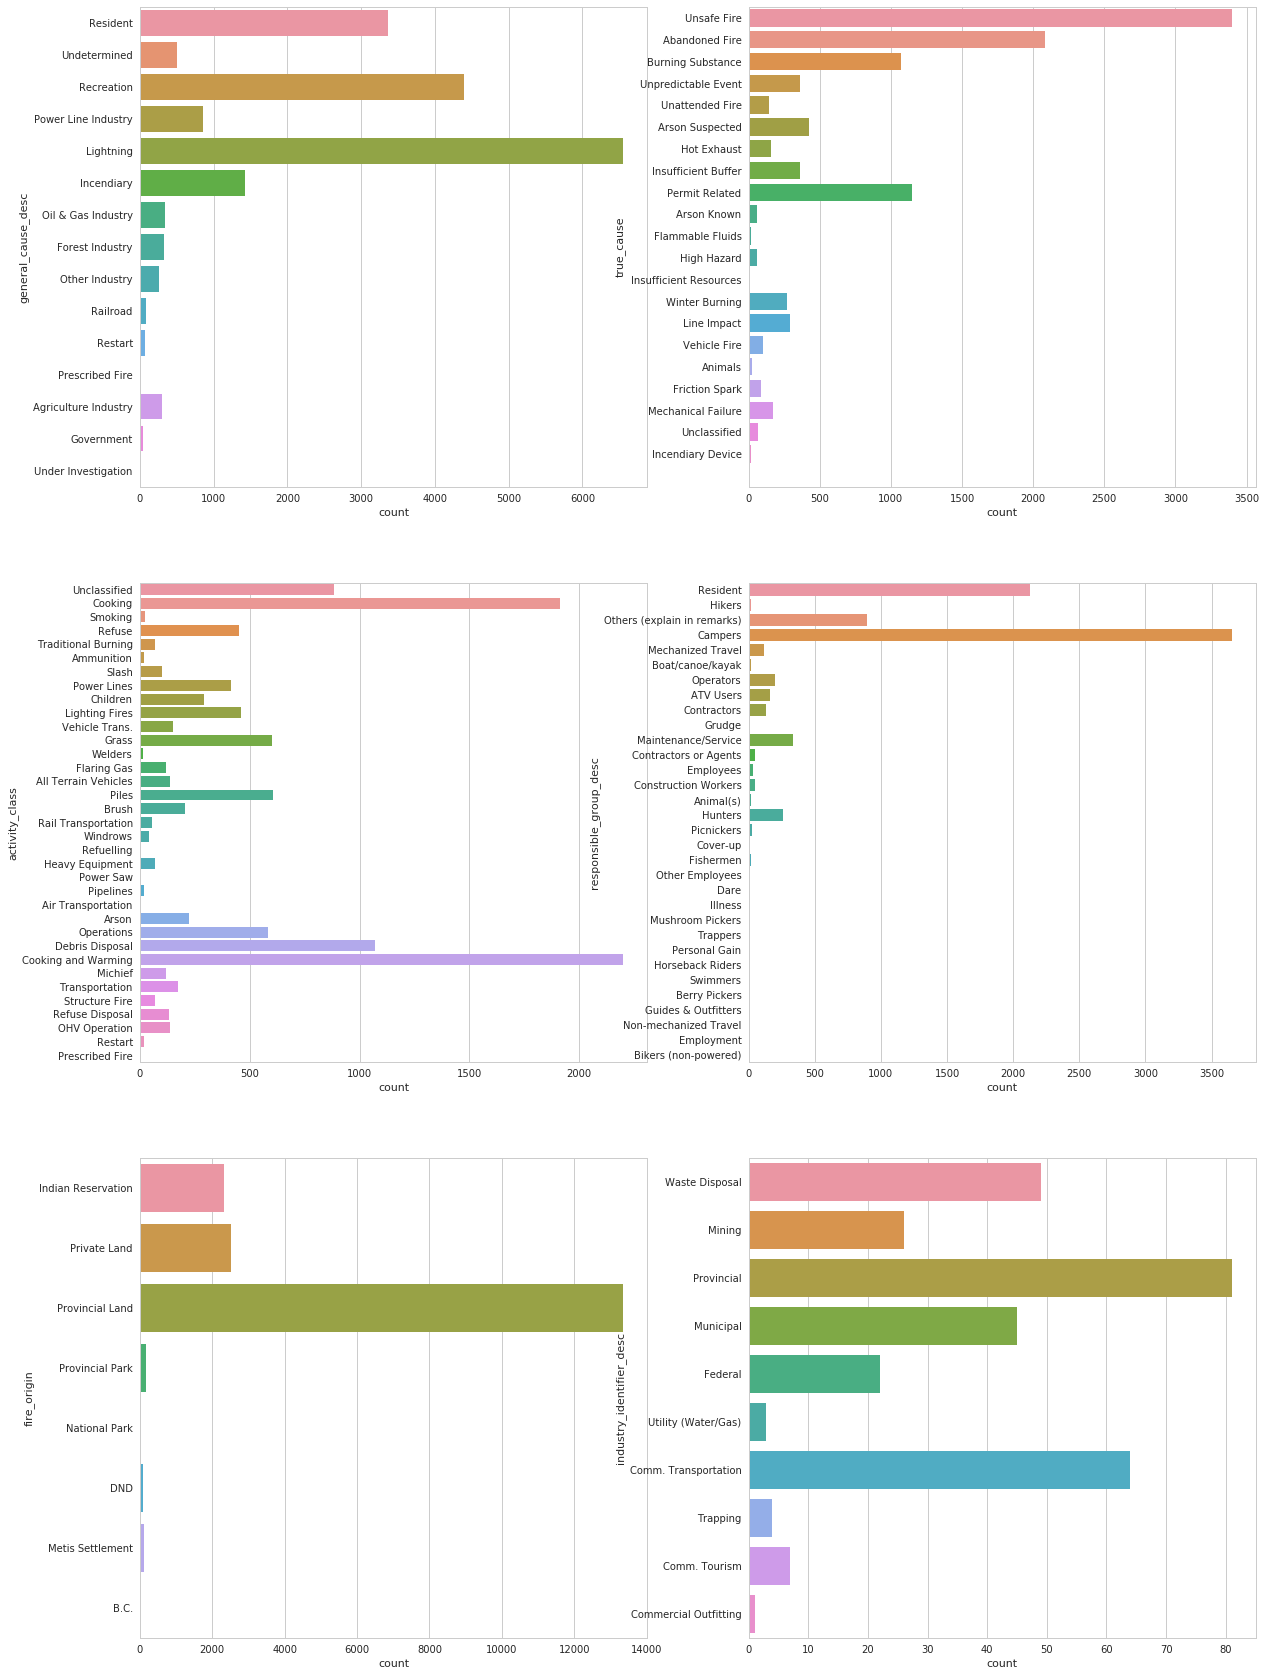

In [70]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,30))
plt.subplot(321)
ax1=sns.countplot(y=wildfire_df2['general_cause_desc'])
plt.subplot(322)
ax1 = sns.countplot(y=wildfire_df2['true_cause'])
plt.subplot(323)
ax2 = sns.countplot(y=wildfire_df2['activity_class'])
plt.subplot(324)
ax2 = sns.countplot(y=wildfire_df2['responsible_group_desc'])
plt.subplot(325)
ax1 = sns.countplot(y=wildfire_df2['fire_origin'])
plt.subplot(326)
ax2 = sns.countplot(y=wildfire_df2['industry_identifier_desc'])
plt.show()

Wildfires detection is sorted into four broad categories: **Unplanned (UNP), Lookout (LKT), Ground Patrol (GRP), Air Patrol (AIR)**. Most detections are unplanned, primarily from the toll-free hotline 310-FIRE, with 7,601 reported cases. The number of detections by lookout towers at 5,585 cases is greater than the detections from air and ground patrols combined, equal to 5,377. The det_agent column contains detailed information regarding the specific agent that detected the wildfire, listing has all 127 fire towers, other government agencies, and types of aircraft. Apart from the 310-FIRE hotline, forest rangers (FRST), wildfire department personnel (LFS), the general public (PUB), and patrolmen (PATR) account for a large portion of detections.

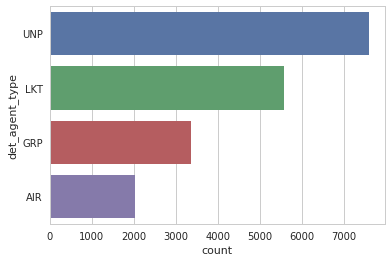

310     2613
FRST    1673
LFS     1631
PUB     1180
PATR    1116
UAA      942
HAC      939
GOVT     711
GARD     567
RW       469
UIND     320
FG       309
MD       257
FW       236
UPA      201
Name: det_agent, dtype: int64

In [71]:
detections_plot = sns.countplot(y=wildfire_df2['det_agent_type'])
plt.show()
wildfire_df2['det_agent'].value_counts(ascending=False).head(15)

The initial_action_by column details the wildfire management resources that provided the first physical suppressive action. The top two categories are FPD staff, representing provincial employees working in wildfire management such as rangers or patrolmen, and Helitack firefighting crews (HAC) which are the primary initial action resource, as shown in the figure below. There appears to be duplicate categories for HAC, so that will be compiled together into one category.

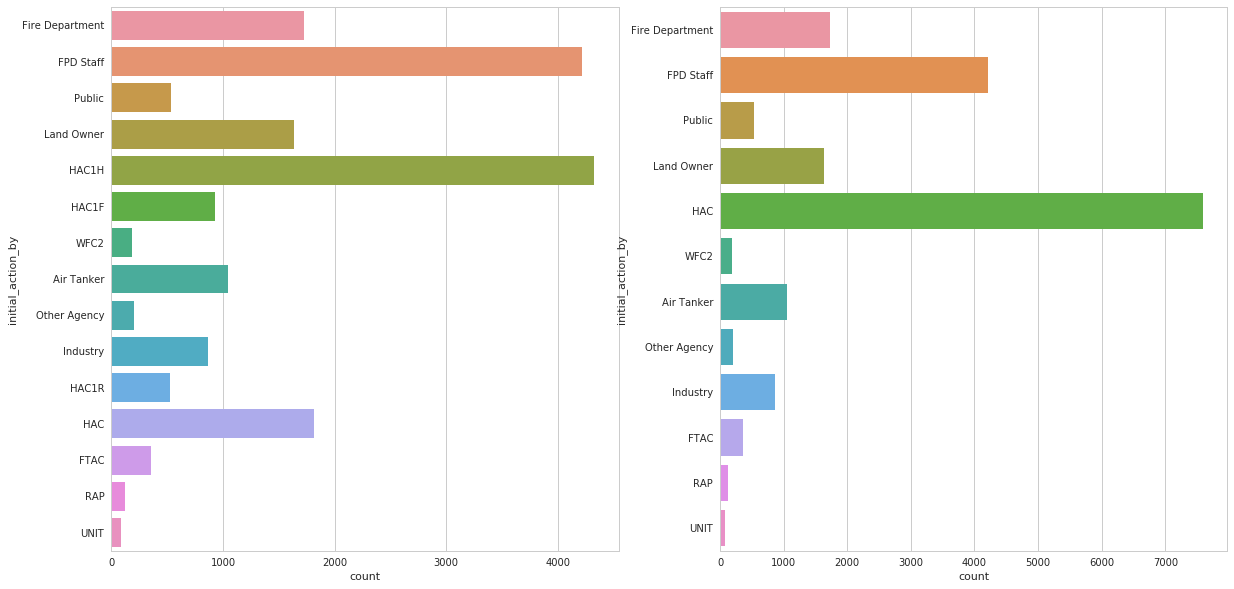

In [72]:
correct_label = "HAC"
plt.figure(figsize=(20,10))
plt.subplot(121)
ax1 = sns.countplot(y=wildfire_df2['initial_action_by'])
wildfire_df2['initial_action_by'].replace("HAC1H", "HAC", inplace=True)
wildfire_df2['initial_action_by'].replace("HAC1F", "HAC", inplace=True)
wildfire_df2['initial_action_by'].replace("HAC1R", "HAC", inplace=True)
plt.subplot(122)
ax2 = sns.countplot(y=wildfire_df2['initial_action_by'])
plt.show()

Below are visualizations of the topographical and weather data provided. The most common initial conditions of wildfires appear to be surface fires on level ground on clear days. All three parameters have unbalanced distributions favouring the most common conditions. Given the [geography of the province of Alberta](https://en.wikipedia.org/wiki/Geography_of_Alberta), where the province is dominated by plains and forests except for the foothills and Rocky Mountains, flat slope is to be expected.<br>

The weather conditions over the wildfires were primarily sunny or cloudy, with a small portion reported as rain showers and Cumulonimbus (CB) clouds, which are often seen on hot summer afternoons throughout Alberta. CB wet clouds are also known as thunderheads and are associated with lightning storms.<br>

The fire type describes the predominant fire behavior that was observed when the fire was first assessed. There are three types: Ground, Surface, and Crown. A ground fire burns primarily in the ground fuel layer, such as grass or dead leaves. A surface fire burns in the surface fuels and involves less than 10% of the trees torching. Campfires, brush piles and windrows that have not burned are examples of these. Crown fire advance through the canopy layer and involves more than 10% of the tree crowns. The largest and most intense fires are typically crown fires.<br>

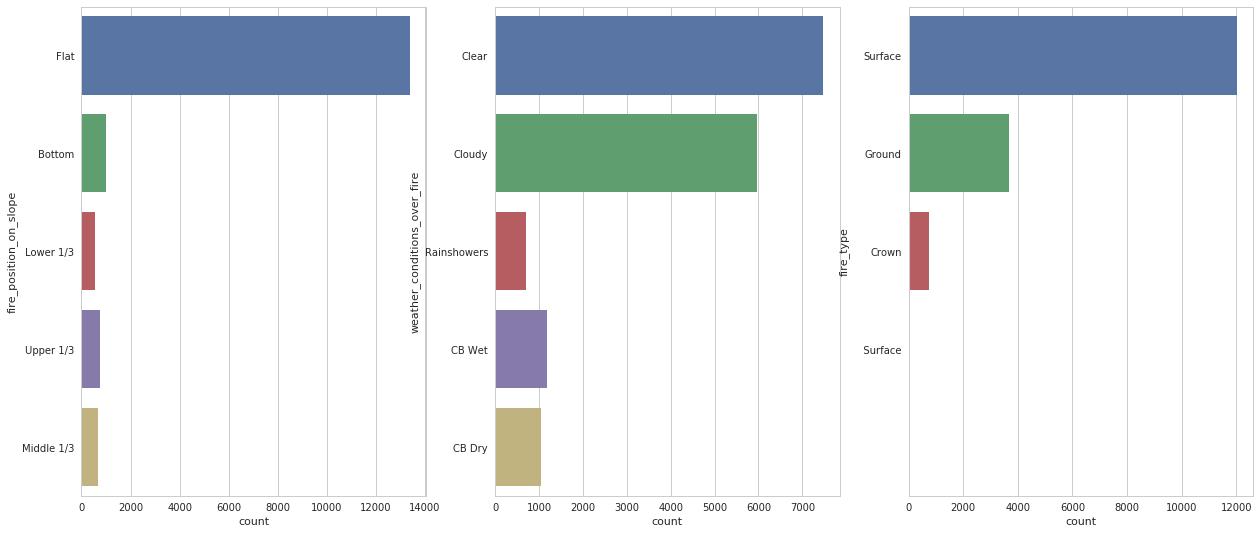

In [73]:
sns.set(style="whitegrid")
plt.figure(figsize=(21,9))
plt.subplot(131)
ax1 = sns.countplot(y=wildfire_df2['fire_position_on_slope'])
plt.subplot(132)
ax2 = sns.countplot(y=wildfire_df2['weather_conditions_over_fire'])
plt.subplot(133)
ax3 = sns.countplot(y=wildfire_df2['fire_type'])
plt.show()

In [74]:
fire_types = wildfire_df2['fire_type'].unique()
print(fire_types)
wildfire_df2['fire_type'].replace(fire_types[-1], np.nan, inplace=True)
wildfire_df2['fire_type'].replace(fire_types[-2], "Surface", inplace=True)
fire_types = wildfire_df2['fire_type'].unique()
print(fire_types)

['Surface' 'Ground' 'Crown' nan '   Surface' '  ']
['Surface' 'Ground' 'Crown' nan]


The various types of fuels in which wildfires are assessed are shown below. The data consists of codes that correspond to the types of [surface fuels and forest types native to Canada](https://cwfis.cfs.nrcan.gc.ca/background/fueltypes/c1). The detailed descriptions are shown in the table below. The two largest categories are boreal spruce and matted grass. The boreal forest is the largest geographical region in the province and covers most of the north, so it makes sense that most of the reported wildfires are detected with this fuel type.<br><br> The fuel codes C7, M3, and M4 only had 9, 2, and 1 samples in the dataset, respectively. Since there are so few of these codes, it would simplify the analysis to just remove these 11 records and reduce the number of fuel codes.

|Code|Description|Code|Description|
|----|-----------|----|-----------| 
|C1|Spruce-Lichen Woodland|M2|Boreal Mixedwood-Green|
|C2|Boreal Spruce|M3|Dead Balsam Fir Mixedwood–Leafless|
|C3|Mature Jack or Lodgepole Pine|M4|Dead Balsam Fir Mixedwood–Green|
|C4|Immature Jack or Lodgepole Pine|O1b|Standing Grass|
|C7|Ponderosa Pine and Douglas Fir|O1a|Matted Grass|
|D1|Leafless Aspen|S1|Jack or Lodgepole Pine Slash|
|M1|Boreal Mixedwood-Leafless|S2|White Spruce–Balsam Slash|

In [75]:
drop_fuel_codes = ['C7','M3',"M4"]
wildfire_df2['fuel_type'].replace(to_replace=drop_fuel_codes, value=np.nan, inplace=True)

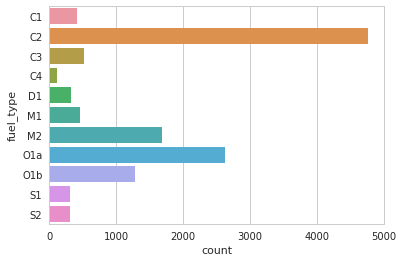

In [76]:
fuel_types_plot = sns.countplot(y=wildfire_df2['fuel_type'].sort_values(ascending=True))

#### Numerical Data Exploration

Now to look at the numerical data provided which consists of the burned area of each wildfire, measured in hectares, at each stage of the wildfire life cycle. Below is the summary statistics of the wildfire sizes showing small mean sizes with large standard deviations. This is expected as the province commits to fast response times to suppress wildfires before they grow too large. The large standard deviations are a result of the extreme outliers representing the largest wildfires.

In [77]:
wildfire_df2.describe(exclude=[np.object])

,assessment_hectares,current_size,fire_fighting_start_size,bh_hectares,uc_hectares,to_hectares,ex_hectares
count,18565.000000,18565.000000,13596.000000,18565.000000,18565.000000,2033.000000,18565.000000
mean,2.416055,142.686577,4.302260,115.666193,154.412112,1.693335,142.686577
std,66.613513,5803.252364,79.806822,6299.465862,6979.767567,11.475042,5803.252364
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
50%,0.010000,0.020000,0.010000,0.010000,0.010000,0.020000,0.020000
75%,0.200000,0.300000,0.280000,0.280000,0.300000,0.200000,0.300000
max,6019.000000,577646.800000,3815.000000,602417.000000,707648.000000,244.200000,577646.800000


The first variable to look at is the current size, which is the final area burned by the fire, after it has been extinguished, further assessed using aerial photography, and interpolated to remove any unburned islands from the aera assessment. This is the value that I wish to predict and understanding the distribution of measurements is important to understand how the regression will be calculated.<br><br> The vast majority of values are very small, skewing the distribution so much that it appears as a single column of values. The skewness and kurtosis of the original data was calculated to 85.7 and 7931.3 which show that distribution is extremely skewed towards lower sizes and is likely to contain large outliers, respectively. A log transformation is typically used to assess skewed data and to make it appear more normally distributed. A comparison between the original and transformed data is shown below. The transformed data had a skewness and kurtosis values of 4.5 and 9.0, respectively.

Original Skewness:  85.73851069047495
Original Kurtosis:  7931.294694469491
Transformed Skewness:  4.451302090952198
Transformed Kurtosis:  8.97857156668332


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


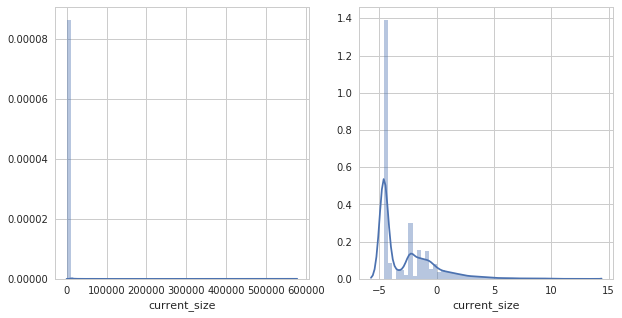

In [78]:
print("Original Skewness: ", wildfire_df2['current_size'].skew())
print("Original Kurtosis: ", wildfire_df2['current_size'].kurt())
print("Transformed Skewness: ", np.log(wildfire_df2['current_size'].skew()))
print("Transformed Kurtosis: ", np.log(wildfire_df2['current_size'].kurt()))
plt.figure(figsize=(10, 5))
plt.subplot(121)
ax1 = sns.distplot(wildfire_df2['current_size'])
plt.subplot(122)
ax1 = sns.distplot(np.log(wildfire_df2['current_size']))
plt.show()

A pairwise comparison of the wildfire sizes, after applying a log transform, is shown below. This is useful to determine the distribution of each size variable as well as the correlation between them. The univariate distribution of each variable is similar in skewness and kurtosis.<br><br> The size data show roughly linear relationships with each other, especially in the later stages of the wildfire life cycle. This is to be expected as the suppression efforts near the end of the lifecycle are usually enough to prevent further growth and is focused on finding hot spots and fully extinguishing the burned area. The bias on one side of the perfectly linear line between the values show the relationships between the variables (i.e., the uh_hectares is typical greater than the bh_hectares because the firefighters are still working to control the spread of the wildfire).<br><br> There is exact linearity between the current_size, to_hectares, and ex_hectares. This is expected because these are all measurements of the wildfire after it has been extinguished and assessed accurately for the actual burned area so this means that two of the three variables can be removed from the analysis without losing information in the models.

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


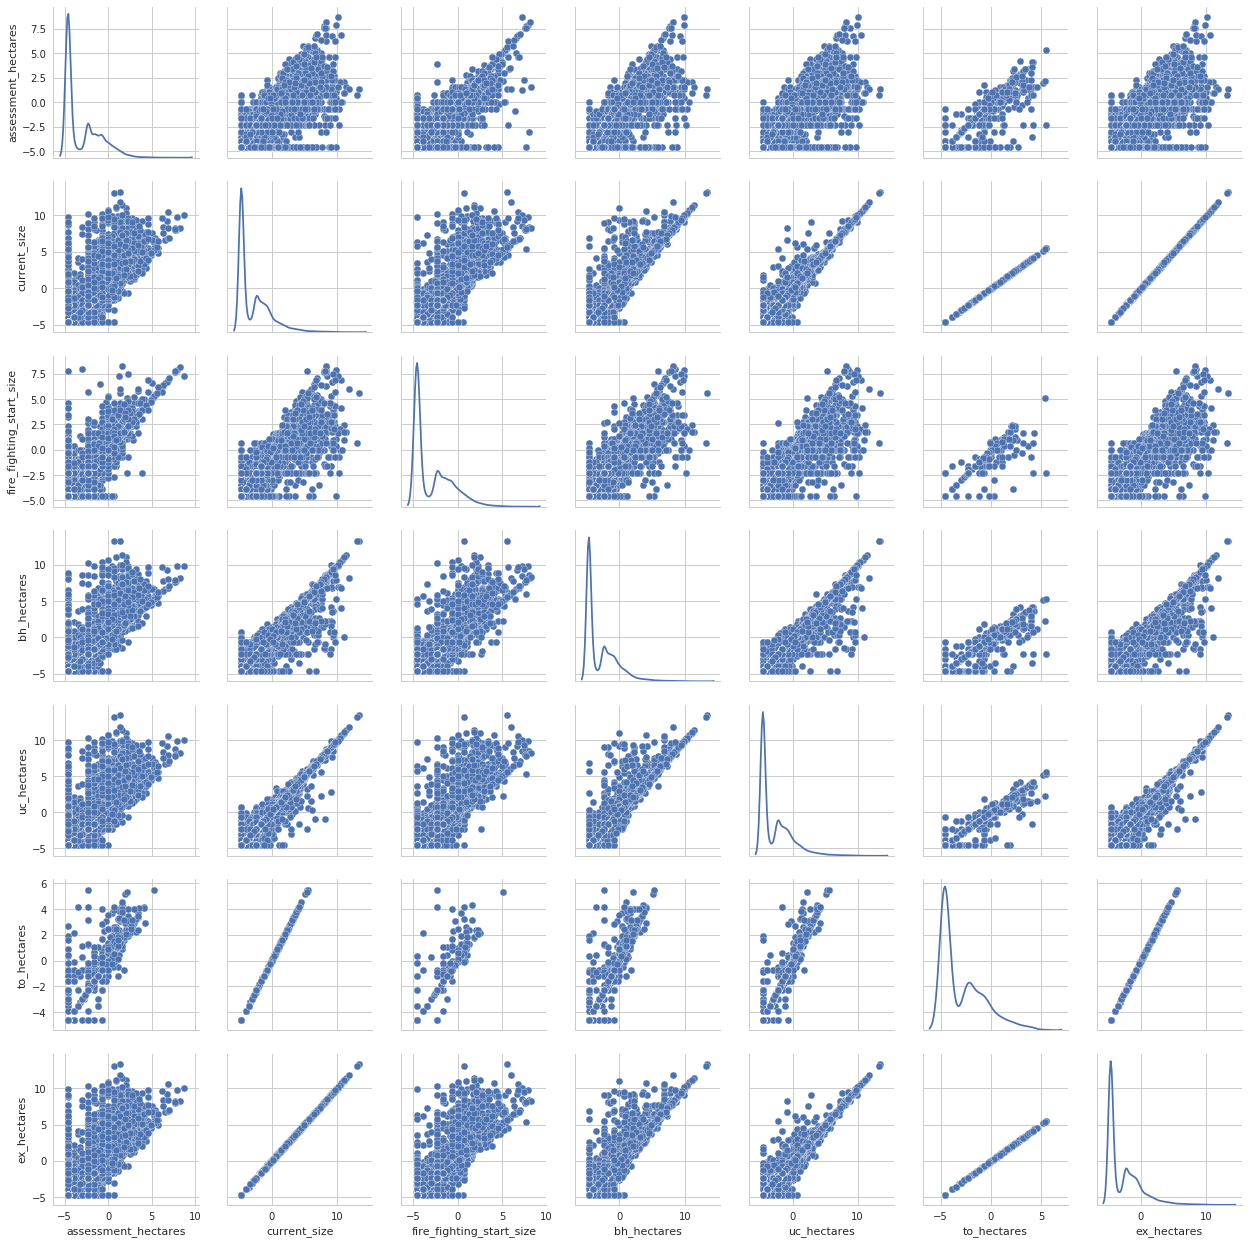

In [79]:
sizes = ['assessment_hectares', 'current_size', 'fire_fighting_start_size', 'bh_hectares',
         'uc_hectares', 'to_hectares', 'ex_hectares']

sns.pairplot(np.log(wildfire_df2[sizes]), diag_kind="kde")

#### Missing Data

Not all variables have values for every reported wildfire. This could be a result of incomplete assessments, human error in the data entry process, or changes to the data tracking or priorities between 2006 and 2017. The percent of null values was calculated in the table below. The variables with the highest percent of missing values as well as redundant variables will be dropped with minimal information loss and to simplify the analysis. The fire_fighting_start date and fuel_type are critical variables in the analysis, so they cannot be removed but have 4,969 and 5,759 missing values, respectively. I will have to drop the rows with the missing values and not use the entire data set for the analysis. There remain a few missing values for the fuel_type, weather_conditions_over_fire, and fire_position_on_slope variables that I instead replaced the missing values with the most common values occurring in the data set. I chose this instead of just removing the rows to keep as much of the original data set as possible. After removing all missing values, 9,725 or 52% wildfire records remain of the original data set.

In [80]:
total = wildfire_df2.isnull().sum().sort_values(ascending=False)
percent = (wildfire_df2.isnull().sum()/wildfire_df2.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
industry_identifier_desc,18263,0.983733
fire_name,18093,0.974576
permit_detail_desc,17771,0.957231
to_hectares,16532,0.890493
to_fs_date,16532,0.890493
other_fuel_type,14961,0.805871
responsible_group_desc,10383,0.559278
true_cause,8251,0.444438
activity_class,7187,0.387126
fuel_type,5764,0.310477


In [81]:
removed_columns = ['industry_identifier_desc',
                   'fire_name',
                   'permit_detail_desc',
                   'responsible_group_desc',
                   'fire_origin',
                   'general_cause_desc',
                   'other_fuel_type',
                   'det_agent',
                   'to_hectares',
                   'ex_hectares',
                   'to_fs_date',
                   'discovered_date',
                   'activity_class',
                   'true_cause',
                   'fire_start_date']
wildfire_df3 = wildfire_df2.drop(removed_columns, axis=1)

In [82]:
wildfire_df3.dropna(subset=['fire_fighting_start_date'], inplace=True)

In [83]:
fuel_types = wildfire_df3['fuel_type'].unique()
weather = wildfire_df3['weather_conditions_over_fire'].unique()
slope = wildfire_df3['fire_position_on_slope'].unique()

wildfire_df3.dropna(subset=['fuel_type'], inplace=True)
wildfire_df3['weather_conditions_over_fire'].replace(np.nan, weather[0], inplace=True)
wildfire_df3['fire_position_on_slope'].replace(np.nan, slope[0], inplace=True)

print(fuel_types)
print(wildfire_df3['fuel_type'].unique())
print(weather)
print(wildfire_df3['weather_conditions_over_fire'].unique())
print(slope)
print(wildfire_df3['fire_position_on_slope'].unique())

[nan 'O1a' 'C2' 'C3' 'O1b' 'M1' 'M2' 'C4' 'C1' 'S1' 'S2' 'D1']
['O1a' 'C2' 'C3' 'O1b' 'M1' 'M2' 'C4' 'C1' 'S1' 'S2' 'D1']
['Cloudy' 'Clear' 'Rainshowers' 'CB Wet' 'CB Dry' nan]
['Clear' 'Cloudy' 'Rainshowers' 'CB Wet' 'CB Dry']
['Bottom' 'Flat' 'Lower 1/3' 'Middle 1/3' 'Upper 1/3' nan]
['Flat' 'Bottom' 'Middle 1/3' 'Upper 1/3' 'Lower 1/3']


In [84]:
print("Before: ", wildfire_df2.shape)
print("After: ", wildfire_df3.shape)
total = wildfire_df3.isnull().sum().sort_values(ascending=False)
percent = (wildfire_df3.isnull().sum()/wildfire_df3.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

Before:  (18565, 34)
After:  (9725, 19)


,Total,Percent
ex_fs_date,0,0.0
fire_fighting_start_size,0,0.0
assessment_hectares,0,0.0
current_size,0,0.0
size_class,0,0.0
det_agent_type,0,0.0
reported_date,0,0.0
start_for_fire_date,0,0.0
fire_fighting_start_date,0,0.0
initial_action_by,0,0.0


#### Datetime Data

First, I want to check that there are no extreme dates within the data set. There are 5 dates in the fire_fighting_start_date column that seem to be typos where the year was inputted incorrectly. These are corrected to the most likely date from observing the other columns.

In [85]:
past_cut_off_date = '2006-01-01 00:00:00'
future_cut_off_date = '2019-01-01 00:00:00'
bad_dates = ((wildfire_df3['reported_date'] > future_cut_off_date) |
             (wildfire_df3['start_for_fire_date'] > future_cut_off_date) |
             (wildfire_df3['fire_fighting_start_date'] > future_cut_off_date) |
             (wildfire_df3['bh_fs_date'] > future_cut_off_date) |
             (wildfire_df3['uc_fs_date'] > future_cut_off_date) |
             (wildfire_df3['ex_fs_date'] > future_cut_off_date) |
             
             (wildfire_df3['reported_date'] < past_cut_off_date) |
             (wildfire_df3['start_for_fire_date'] < past_cut_off_date) |
             (wildfire_df3['fire_fighting_start_date'] < past_cut_off_date) |
             (wildfire_df3['bh_fs_date'] < past_cut_off_date) |
             (wildfire_df3['uc_fs_date'] < past_cut_off_date) |
             (wildfire_df3['ex_fs_date'] < past_cut_off_date)
            )
bad_dates.value_counts()
typos = wildfire_df3.loc[bad_dates]
typos

,assessment_datetime,assessment_hectares,current_size,size_class,det_agent_type,reported_date,start_for_fire_date,fire_fighting_start_date,fire_fighting_start_size,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,ex_fs_date
2009-GWF056,2009-06-12 10:45:00,0.01,0.01,A,UNP,2009-06-12 08:15:00,2009-06-12 10:21:00,2090-06-12 10:52:00,0.01,WFC2,Surface,Bottom,Clear,M2,2009-06-12 10:45:00,0.01,2009-06-12 11:05:00,0.01,2009-06-12 12:51:00
2009-SWF016,2009-05-01 20:39:00,0.50,0.50,B,AIR,2009-05-01 20:26:00,2009-05-01 20:26:00,2090-05-01 20:45:00,0.50,HAC,Surface,Flat,Clear,O1b,2009-05-01 20:39:00,0.50,2009-05-01 21:18:00,0.50,2009-05-02 11:20:00
2010-EWF023,2010-04-13 09:05:00,0.01,0.01,A,UNP,2010-04-13 08:54:00,2010-04-13 08:56:00,2020-04-13 09:05:00,0.01,FPD Staff,Surface,Flat,Cloudy,O1a,2010-04-13 09:05:00,0.01,2010-04-13 09:05:00,0.01,2010-04-13 09:10:00
2015-WWF011,2015-05-09 14:52:00,0.50,0.33,B,UNP,2015-05-09 12:55:00,2015-05-09 13:18:00,2050-05-09 14:52:00,0.33,HAC,Surface,Upper 1/3,Clear,O1a,2015-05-09 14:52:00,0.50,2015-05-09 15:05:00,0.50,2015-05-09 18:51:00
2016-PWF071,2016-06-25 14:35:00,0.01,0.01,A,LKT,2016-06-25 14:23:00,2016-06-25 14:24:00,2160-06-25 15:07:00,0.01,HAC,Surface,Flat,Cloudy,C2,2016-06-25 15:08:00,0.01,2016-06-25 15:20:00,0.01,2016-06-25 15:38:00


In [86]:
typo_index = typos.index
wildfire_df3.loc[typo_index[0], 'fire_fighting_start_date'] = '2009-06-12 10:52:00'
wildfire_df3.loc[typo_index[1], 'fire_fighting_start_date'] = '2009-05-01 20:45:00'
wildfire_df3.loc[typo_index[2], 'fire_fighting_start_date'] = '2010-04-13 09:05:00'
wildfire_df3.loc[typo_index[3], 'fire_fighting_start_date'] = '2015-05-09 14:52:00'
wildfire_df3.loc[typo_index[4], 'fire_fighting_start_date'] = '2016-06-25 15:07:00'

print('Before:\n', typos['fire_fighting_start_date'])
print('After:\n', wildfire_df3.loc[bad_dates]['fire_fighting_start_date'])

Before:
 2009-GWF056    2090-06-12 10:52:00
2009-SWF016    2090-05-01 20:45:00
2010-EWF023    2020-04-13 09:05:00
2015-WWF011    2050-05-09 14:52:00
2016-PWF071    2160-06-25 15:07:00
Name: fire_fighting_start_date, dtype: object
After:
 2009-GWF056    2009-06-12 10:52:00
2009-SWF016    2009-05-01 20:45:00
2010-EWF023    2010-04-13 09:05:00
2015-WWF011    2015-05-09 14:52:00
2016-PWF071    2016-06-25 15:07:00
Name: fire_fighting_start_date, dtype: object


The features to be used for the regression is the duration of time between fire stages. The first time delta is from when the fire is reported to when the fire is assessed, called the Assessment Duration. The Start for Fire Duration and Initial Action Duration are the differences between the start_for_fire_date and fire_fighting_start_date with the reported_date, respectively. The BH Duration is the difference between the  bh_fs_date and the assessment_date. The UC and EX Durations are the time deltas between the bh_fs_date, uc_fs_date, and the ex_fs_date, chronologically. 

In [87]:
date_times = ['assessment_datetime', 'start_for_fire_date', 'reported_date', 
              'fire_fighting_start_date', 'bh_fs_date', 'uc_fs_date','ex_fs_date']

assessment_time = pd.to_datetime(wildfire_df3['assessment_datetime'])
sff_time = pd.to_datetime(wildfire_df3['start_for_fire_date'])
report_time = pd.to_datetime(wildfire_df3['reported_date'])
ffs_time = pd.to_datetime(wildfire_df3['fire_fighting_start_date'])
bh_time = pd.to_datetime(wildfire_df3['bh_fs_date'])
uc_time = pd.to_datetime(wildfire_df3['uc_fs_date'])
ex_time = pd.to_datetime(wildfire_df3['ex_fs_date'])

assessment_dt = (assessment_time - report_time)/np.timedelta64(1,'m')
sff_dt = (sff_time - report_time)/np.timedelta64(1,'m')
ffs_dt = (ffs_time - report_time)/np.timedelta64(1,'m')
bh_dt = (bh_time - assessment_time)/np.timedelta64(1,'m')
uc_dt = (uc_time - bh_time)/np.timedelta64(1,'m')
ex_dt = (ex_time - uc_time)/np.timedelta64(1,'m')

keys=['assessment_duration', 'start_for_fire_duration', 'initial_action_duration',
      'bh_duration', 'uc_duration', 'ex_duration']

time_durations_df = pd.concat([assessment_dt, sff_dt, ffs_dt, bh_dt, uc_dt, ex_dt], axis=1, keys=keys)
time_durations_df.describe()

,assessment_duration,start_for_fire_duration,initial_action_duration,bh_duration,uc_duration,ex_duration
count,9725.000000,9725.00000,9725.000000,9725.000000,9725.000000,9725.000000
mean,112.877018,86.57419,484.735424,326.360514,1137.167712,4548.542725
std,672.205447,657.62661,9810.525204,1839.738514,6208.361788,25332.557819
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.00000,21.000000,0.000000,0.000000,40.000000
50%,22.000000,5.00000,42.000000,26.000000,55.000000,136.000000
75%,47.000000,15.00000,85.000000,100.000000,360.000000,1320.000000
max,41221.000000,41221.00000,528233.000000,61481.000000,186751.000000,567865.000000


A correlation matrix is created of these time deltas to see if one or more of these variables can be removed without losing information. As shown in the heatmap below, there is high correlation between the Assessment and Start for Fire Durations. This is most likely due to the large amount of fires detected by personnel that initiate suppression actions, such as a HAC crew out on a patrol or a forest officer overseeing a permitted fire. I plan to take out the start_for_fire data columns as I believe the assessment time duration is a more meaningful metric to use in the regression. There is some correlation in the later time deltas, suggesting that the duration of wildfire suppression efforts is more evenly distributed amongst the wildfire stages. In other words, the time intervals between the BH, UC, and EX states are roughly equal.

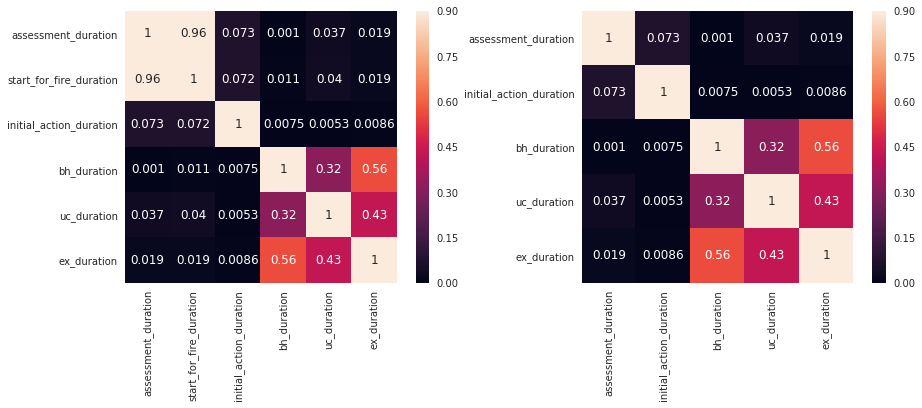

In [88]:
corrmat = time_durations_df.corr()
plt.figure(figsize=(15,5))
plt.subplot(121)
ax1=sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)
time_durations_df2 = time_durations_df.drop(columns='start_for_fire_duration')
corrmat2 = time_durations_df2.corr()
plt.subplot(122)
ax2=sns.heatmap(corrmat2, vmax=0.9, square=True, annot=True)
plt.show()

Now to drop the date time columns from the wildfire data sets and combine it with the duration data table.

In [89]:
print('Before Drop: ', wildfire_df3.shape)
wildfire_df4 = wildfire_df3.drop(columns=date_times)
print('After Drop: ', wildfire_df4.shape)
wildfire_df4 = wildfire_df4.join(time_durations_df2)
print('After Combine: ', wildfire_df4.shape)
wildfire_df4.head()

Before Drop:  (9725, 19)
After Drop:  (9725, 12)
After Combine:  (9725, 17)


,assessment_hectares,current_size,size_class,det_agent_type,fire_fighting_start_size,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_hectares,uc_hectares,assessment_duration,initial_action_duration,bh_duration,uc_duration,ex_duration
2006-CWF012,0.10,0.10,A,LKT,0.10,HAC,Surface,Flat,Clear,O1a,0.10,0.10,3.0,3.0,4.0,0.0,50.0
2006-CWF020,0.01,0.01,A,UNP,0.01,HAC,Surface,Flat,Clear,O1a,0.01,0.01,3.0,3.0,0.0,0.0,11.0
2006-CWF022,0.20,0.20,B,UNP,0.20,HAC,Surface,Bottom,Clear,O1a,0.20,0.20,8.0,15.0,27.0,0.0,770.0
2006-CWF023,0.01,0.01,A,UNP,0.01,HAC,Surface,Bottom,Clear,O1a,0.01,0.01,6.0,15.0,0.0,0.0,31.0
2006-CWF024,0.01,0.01,A,LKT,0.01,HAC,Surface,Bottom,Clear,O1a,0.01,0.01,27.0,29.0,0.0,0.0,713.0


## Methodology

There will be three types of algorithms to be used to classify and predict the final size of wildfires in Alberta: PCA, k-means clustering, and linear regression. The PCA algorithm will be used to perform dimension reduction on the processed data and extract a small number of features to explain the data. K-means clustering will be used to classify the wildfires into the fire groups, like the size class variable given in the original data set. The difference between these fire groups and the size_class variable is that they will consider all the available data to find relationships instead of relying solely on the final size of the burned area. Finally, a regression model on the fire groups using the duration between stages in the wildfire life cycle will be created to predict the final burned area of new wildfires. Linear regression will be explored first, as it is the simplest model, but more advanced models may be used to predict the size of new wildfires.

### Benchmark

The data set contains a classification of wildfires based solely on the final size of the burned area, which will be a used as a metric to compare the new fire groups to. The distribution and descriptive statistics of the wildfires in both classification systems will be compared to discuss if the new classification method is relevant.<br><br> The number of fire groups will be determined by maximizing the average Silhouette Coefficient for various number of groups. After the wildfires are classified, the data set will be split into training and test data used to create and validate the regression model. Each fire group will have its own regression model to estimate the final burned area of the type of wildfire as a function of the duration between wildfire management phases.
A pie chart of the size classes is shown below. The size classes are divided into five categories: A (less than 0.1 ha), B (between 0.1 ha and 4.0 ha), C (between 4.0 ha and 40.0 ha), D (between 40.0 ha and 200 ha), and E (greater than 200 ha). Approximately 90% of the reported wildfires were less than 4.0 ha with a combined burned area of 2,918 ha. 98% of the total burned area between 2006 and 2017 is due to only 253 wildfires.


,Size Class,Size Class Percent,Burned Area,Burned Area Percent
A,5232,0.537995,187.25,0.000072
B,3381,0.347661,2730.52,0.001047
C,650,0.066838,8548.81,0.003278
D,209,0.021491,18684.22,0.007164
E,253,0.026015,2578027.31,0.988440


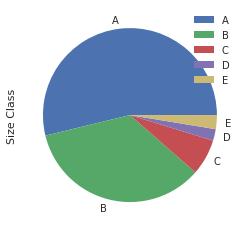

In [90]:
classes = wildfire_df4.groupby(['size_class'])['current_size'].count().sort_values(ascending=False)
percent = classes/classes.sum()
burned_area = wildfire_df4.groupby(['size_class'])['current_size'].sum().sort_values(ascending=False)
burned_percent = burned_area/burned_area.sum()
class_summary = pd.concat([classes, percent, burned_area, burned_percent],
                          axis=1, keys=['Size Class', 'Size Class Percent', 'Burned Area', 'Burned Area Percent'], sort=True)
class_summary.plot.pie(y='Size Class')
class_summary

### Data Preprocessing

The first pre-processing step is to encode the categorical data in order to create models for classification and regression. The nominal data in the det_agent_type, initial_action_by, fire_position_on_slope, weather_conditions_over_fire, and fuel_type will be representing as integer values using the one-hot encoding method. The fire_type category can be represented using ordinal encoding to show the relative intensity between surface and crown fires and the size_class column will also be dropped since it is no longer needed. Since we will be classifying the wildfires on the initial observed state, the fire_fighting_start_size, bh_hectares, and uc_hectares will also be removed and the only remaining size measurement will be the assessment_hectares. The current_size and duration between wildfire states will be saved for training the regression algorithm later.

In [91]:
encoded_columns = ['det_agent_type', 'initial_action_by', 'fire_position_on_slope', 'weather_conditions_over_fire', 'fuel_type']
dropped_columns = ['bh_hectares', 'uc_hectares', 'size_class', 'fire_fighting_start_size']
regression_columns=['assessment_duration', 'initial_action_duration', 'bh_duration', 'uc_duration', 'ex_duration', 'current_size']

wildfire_regression = wildfire_df4[regression_columns] # Save for regression models later
wildfire_df5 = pd.get_dummies(wildfire_df4, columns=encoded_columns)
wildfire_df5.drop(dropped_columns, axis=1, inplace=True)

wildfire_df5.drop(regression_columns, axis=1, inplace=True)
print("Before: ", wildfire_df4.shape)
print("After: ", wildfire_df5.shape)

fire_types = pd.Categorical(wildfire_df4['fire_type'],
                            categories = ['Surface', 'Ground', 'Crown'],
                            ordered = True)

labels, unique = pd.factorize(fire_types, sort=True)
wildfire_df5['fire_type'] = labels

Before:  (9725, 17)
After:  (9725, 34)


The next step is to scale and standardize the observed state data in order to prevent difficulties in the classification algorithms. Due to the presence of extreme outliers in this data set, which cannot be removed, the standard scalers will not work well so the power transformer from sklearn will be used to make the input data more Gaussian. The transformer will have to use the Yeo-Johnson transform due to the numerous zero values in the data.

In [92]:
from sklearn.preprocessing import PowerTransformer

wildfire_df6 = wildfire_df5.iloc[:,:10]
transformer = PowerTransformer()
wildfire_df7 = pd.DataFrame(transformer.fit_transform(wildfire_df6.astype(float)))

wildfire_df7.columns = wildfire_df6.columns
wildfire_df7.index = wildfire_df6.index

wildfire_df7.describe()

,assessment_hectares,fire_type,det_agent_type_AIR,det_agent_type_GRP,det_agent_type_LKT,det_agent_type_UNP,initial_action_by_Air Tanker,initial_action_by_FPD Staff,initial_action_by_FTAC,initial_action_by_HAC
count,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03
mean,-1.567098e-16,-4.471350e-15,1.020343e-15,-3.771904e-16,-2.458747e-15,-3.136708e-16,7.266395e-17,-3.375957e-15,-1.992442e-14,5.051852e-15
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-4.984101e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,-1.443733e+00
25%,-4.984101e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,-1.443733e+00
50%,-3.696878e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,6.926490e-01
75%,9.802439e-02,1.277060e+00,-4.526933e-01,-1.471086e-01,1.170069e+00,1.259538e+00,-3.445522e-01,-4.224952e-01,-1.768704e-01,6.926490e-01
max,1.261043e+01,2.373137e+00,2.209001e+00,6.797701e+00,1.170069e+00,1.259538e+00,2.902318e+00,2.366891e+00,5.653857e+00,6.926490e-01


Now to place all of the data back into a single DataFrame to move to the next step of feature extraction, Principle Component Analysis (PCA).

In [93]:
wildfire_df8 = wildfire_df5.copy()
wildfire_df8.iloc[:,:10] = wildfire_df7
wildfire_df8.describe()

,assessment_hectares,fire_type,det_agent_type_AIR,det_agent_type_GRP,det_agent_type_LKT,det_agent_type_UNP,initial_action_by_Air Tanker,initial_action_by_FPD Staff,initial_action_by_FTAC,initial_action_by_HAC,initial_action_by_RAP,initial_action_by_UNIT,initial_action_by_WFC2,fire_position_on_slope_Bottom,fire_position_on_slope_Flat,fire_position_on_slope_Lower 1/3,fire_position_on_slope_Middle 1/3,fire_position_on_slope_Upper 1/3,weather_conditions_over_fire_CB Dry,weather_conditions_over_fire_CB Wet,weather_conditions_over_fire_Clear,weather_conditions_over_fire_Cloudy,weather_conditions_over_fire_Rainshowers,fuel_type_C1,fuel_type_C2,fuel_type_C3,fuel_type_C4,fuel_type_D1,fuel_type_M1,fuel_type_M2,fuel_type_O1a,fuel_type_O1b,fuel_type_S1,fuel_type_S2
count,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000
mean,-1.567098e-16,-4.471350e-15,1.020343e-15,-3.771904e-16,-2.458747e-15,-3.136708e-16,7.266395e-17,-3.375957e-15,-1.992442e-14,5.051852e-15,0.012339,0.007609,0.016350,0.047506,0.826838,0.033830,0.041645,0.050180,0.084730,0.110643,0.432288,0.329254,0.043085,0.039383,0.468689,0.044422,0.009460,0.021285,0.032699,0.143033,0.148586,0.062005,0.018098,0.012339
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,0.110401,0.086903,0.126823,0.212730,0.378407,0.180802,0.199787,0.218327,0.278494,0.313705,0.495419,0.469967,0.203059,0.194515,0.499044,0.206040,0.096807,0.144341,0.177857,0.350125,0.355698,0.241177,0.133312,0.110401
min,-4.984101e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,-1.443733e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-4.984101e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,-1.443733e+00,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-3.696878e-01,-5.966934e-01,-4.526933e-01,-1.471086e-01,-8.546502e-01,-7.939419e-01,-3.445522e-01,-4.224952e-01,-1.768704e-01,6.926490e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.802439e-02,1.277060e+00,-4.526933e-01,-1.471086e-01,1.170069e+00,1.259538e+00,-3.445522e-01,-4.224952e-01,-1.768704e-01,6.926490e-01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.261043e+01,2.373137e+00,2.209001e+00,6.797701e+00,1.170069e+00,1.259538e+00,2.902318e+00,2.366891e+00,5.653857e+00,6.926490e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Principle Component Analysis (PCA)

To complete the PCA I followed the procedure as shown in the example project of population segmentation provided [here](https://github.com/udacity/ML_SageMaker_Studies/blob/master/Population_Segmentation/Pop_Segmentation_Solution.ipynb). The time duration data will be excluded from this analysis as these are the features I want to use in the regression analysis later. I used the PCA model from sklearn to compute the principle components and plotted the explained variance as a function of the number of components used (shown below), as detailed [here](https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe). By using 10 components, just under one third of the original feature space, about 90% of the variance is captured.

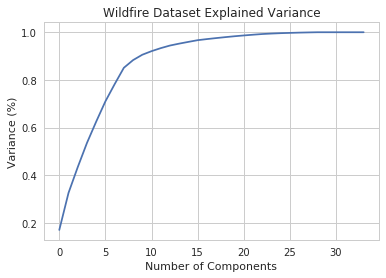

In [94]:
from sklearn.decomposition import PCA
pca = PCA().fit(wildfire_df8)

explained_variance = np.cumsum(pca.explained_variance_ratio_)
plt.figure()
plt.plot(explained_variance)
plt.xlabel("Number of Components")
plt.ylabel("Variance (%)")
plt.title('Wildfire Dataset Explained Variance')
plt.show()

The PCA is re-fit to the data using 10 components. To visualize the composition of the principle components, I modified the make-up visualization from the example project of population segmentation provided [in this tutorial](https://github.com/udacity/ML_SageMaker_Studies/blob/master/Population_Segmentation/Pop_Segmentation_Solution.ipynb) to plot the composition of all 10 principle components. Only the top 10 weights of the original data are displayed in each component.<br><br> Through inspection of the composition plots, it appears that the type of initial action and detection resources, assessment size, and fire types are integral parameters to explain the variance in the data set. Lookouts, air and ground patrols appear to be dominant variables in explaining the variation in the data set.

In [95]:
components=10
v=pd.DataFrame(pca.components_)
pca = PCA(n_components=components)
wildfire_df9 = pd.DataFrame(pca.fit_transform(wildfire_df8), index=wildfire_df8.index)

In [96]:
def component_composition(v, features_list, component_num, n_weights=10):
    
    v_1_row = v.iloc[:, component_num]
    v_1 = np.squeeze(v_1_row.values)
    component_name = "Component " + str(component_num + 1) + " Features"
    component_weights =  "Component " + str(component_num + 1) + " Weights"
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=[component_weights, component_name])

    # we'll want to sort by the largest n_weights by magnitude
    comps['abs_weights']=comps[component_weights].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)
    return sorted_weight_data

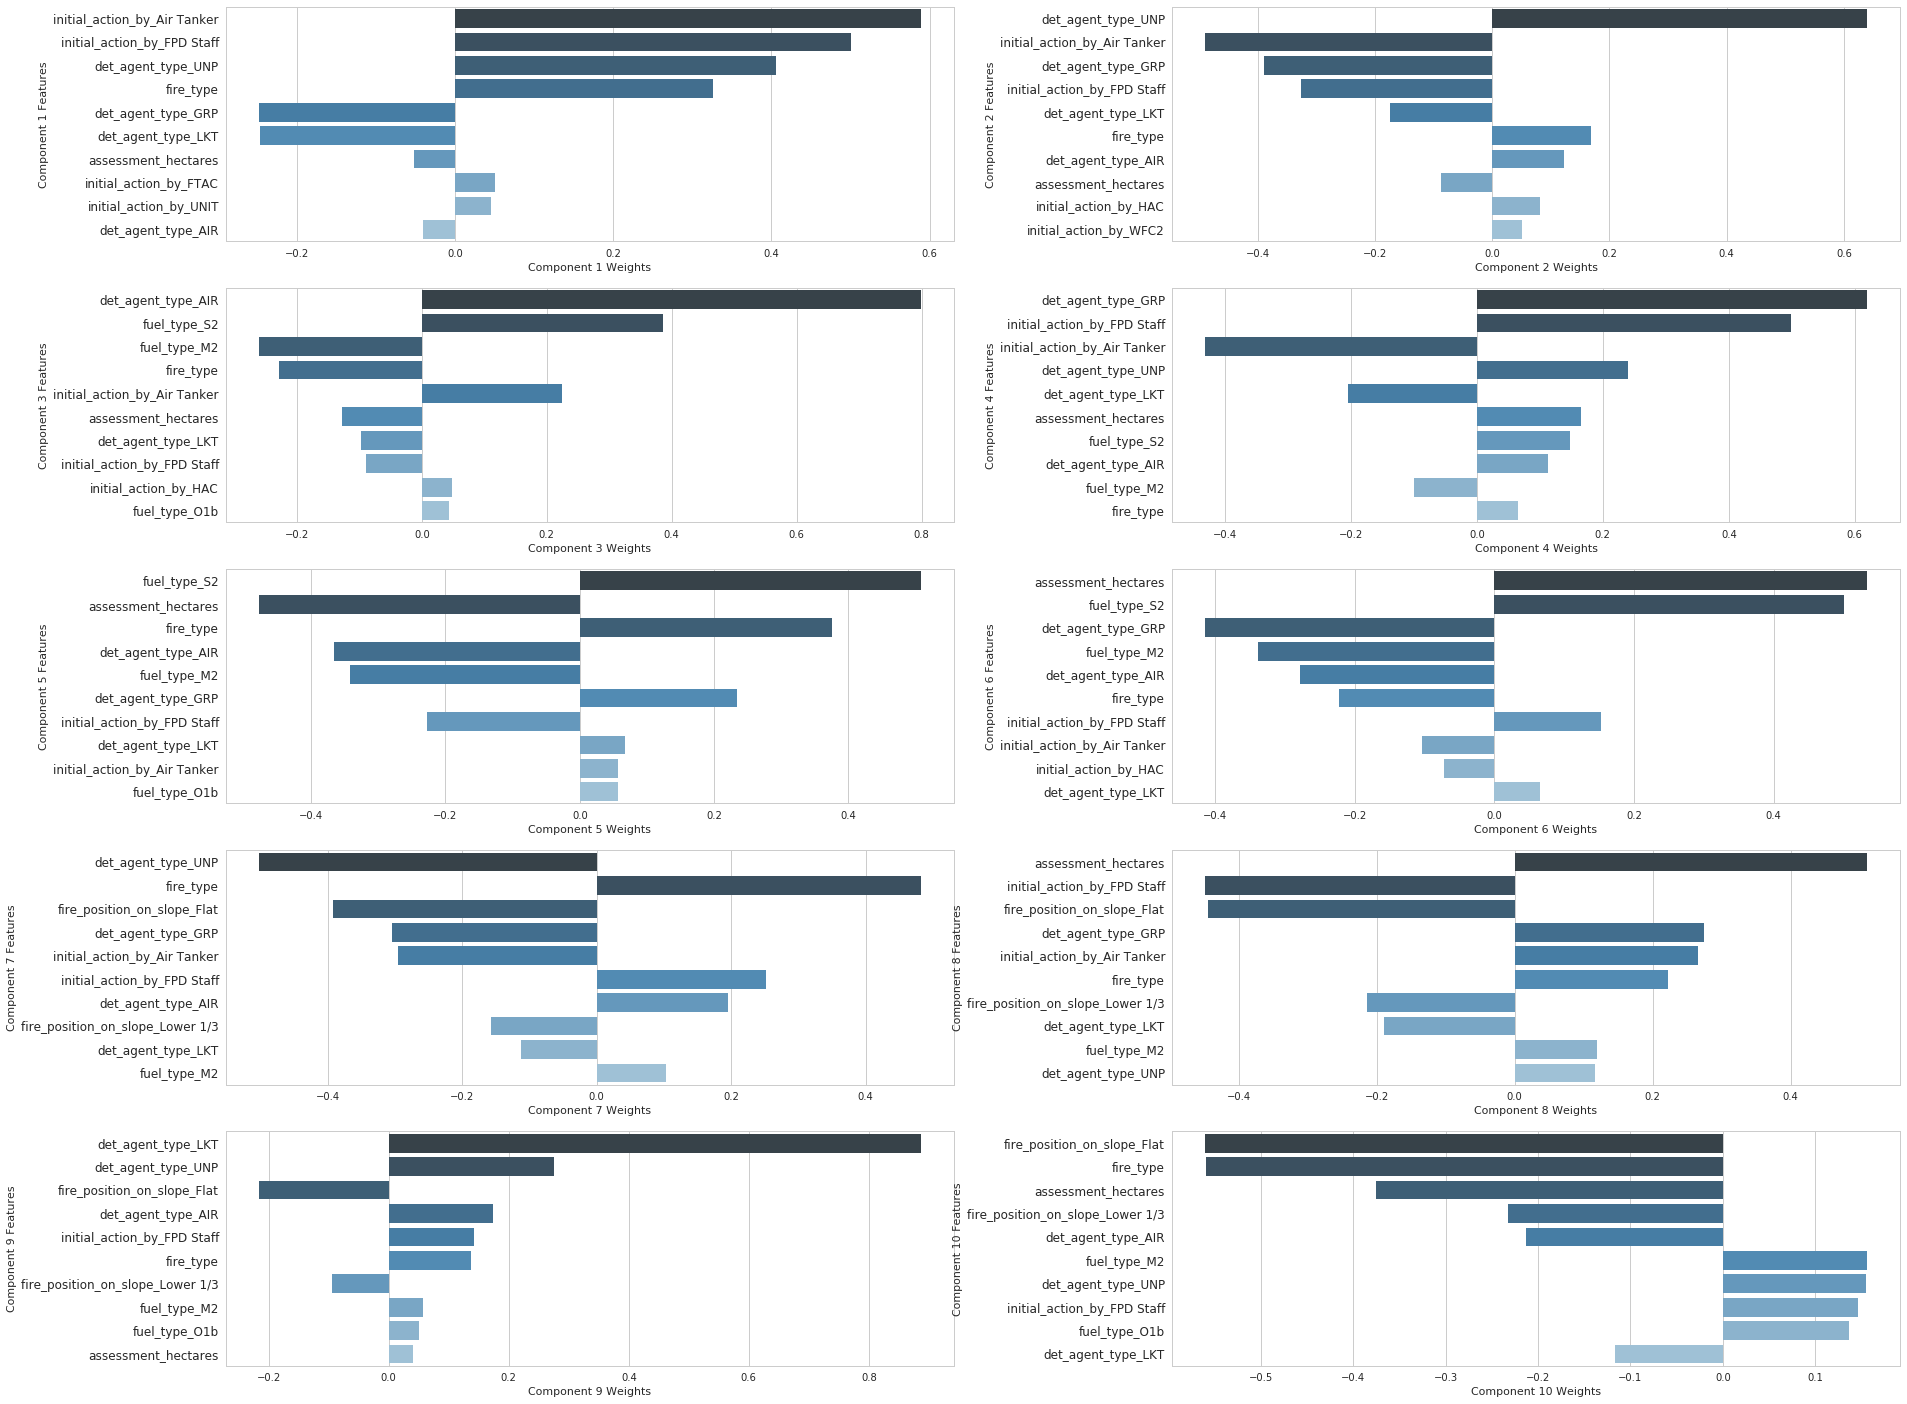

In [103]:
fig=plt.figure(figsize=(30,25))
fig.subplots_adjust(hspace=0.2, wspace=0.3)
for num in range(components):
    component_name = "Component " + str(num + 1) + " Features"
    component_weights =  "Component " + str(num + 1) + " Weights"
    comp = component_composition(v, wildfire_df8.columns.values, component_num=num)
    ax = fig.add_subplot(5,2,num + 1)
    sns.barplot(data=comp, x=component_weights, y=component_name, palette="Blues_d")
    plt.yticks(fontsize = 12)
plt.show()

## Implementation

### Fire Group Classification

To segment the wildfires using their PCA components in distinct fire groups based on the observed initial state, k-means clustering was used to find relationships on the principle components. To start, I used the same number of size categories given in the original dataset. This provided a direct comparison between the two classification systems. After, the quality of the clustering results was optimized using the average Silhouette Coefficient to determine an optimal number of groupings.

In [33]:
from sklearn.cluster import KMeans

In [34]:
fire_groups = 5
kmeans = KMeans(n_clusters = fire_groups, random_state = 0)
kmeans.fit(wildfire_df9)
fire_labels = kmeans.labels_.reshape(-1,1) + 1

The labels from the k-means clustering algorithm were applied to the pre-processed data used to summarize the size classes. The fire groups are compared to the original size classes in the pie plots and summary table below. It appears to be more evenly distributed, which is to be expected using the k-means clustering algorithm, but the biggest difference is the distribution of the total burned area. The fire group with the largest burned area is group 2 but only accounts for 32% of the total burned area. Roughly half of the wildfires are classified in fire groups 2 and 5, which also account for 53% of the burned area.

In [35]:
wildfire_df10 = wildfire_df4.copy()
wildfire_df10['Fire_Group'] = fire_labels

In [36]:
fire_groups = wildfire_df10.groupby(['Fire_Group'])['current_size'].count().sort_values(ascending=False)
fg_percent = fire_groups / fire_groups.sum()
fg_burned_area = wildfire_df10.groupby(['Fire_Group'])['current_size'].sum().sort_values(ascending=False)
fg_burned_percent = fg_burned_area / fg_burned_area.sum()
fire_group_summary = pd.concat([fire_groups, fg_percent, fg_burned_area, fg_burned_percent],
                          axis=1, keys=['Fire_Group', 'Fire_Group_Percent', 
                                        'Fire_Group_Burned_Area', 'Fire_Group_Burned_Area_Percent'], sort=True)

,Fire_Group,Fire_Group_Percent,Fire_Group_Burned_Area,Fire_Group_Burned_Area_Percent
Fire_Group,,,,
1,1484,0.152596,241170.93,0.092467
2,3132,0.322057,1104960.71,0.423652
3,1420,0.146015,550542.31,0.211083
4,1032,0.106118,438891.82,0.168275
5,2657,0.273213,272612.34,0.104522


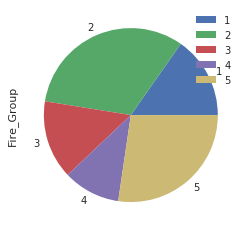

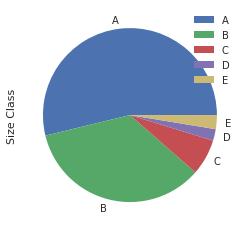

In [37]:
pie1 = fire_group_summary.plot.pie(y='Fire_Group')
pie2 = class_summary.plot.pie(y='Size Class')
fire_group_summary

To analyze the fire groups more closely, I will again borrow a visualization from [here](https://github.com/udacity/ML_SageMaker_Studies/blob/master/Population_Segmentation/Pop_Segmentation_Solution.ipynb) to study the distribution of principle components within the clusters by creating a heatmap of the cluster centers. Only the first eight components were really used to define the clusters. Cluster 1 primarily used component 1 which was heavily weighted towards the initial suppression and assessment detection resource type. Cluster 2 comprised mainly from components 1 and 3 which were greatly influenced by fuel types. Cluster 3 was mostly weighted on components 2 and 3. Cluster 4 had the highest weight across the clusters on component 2 which is also weighted towards the initial suppression and assessment detection resource type. Cluster 5 is more evenly weighted across most of the components.

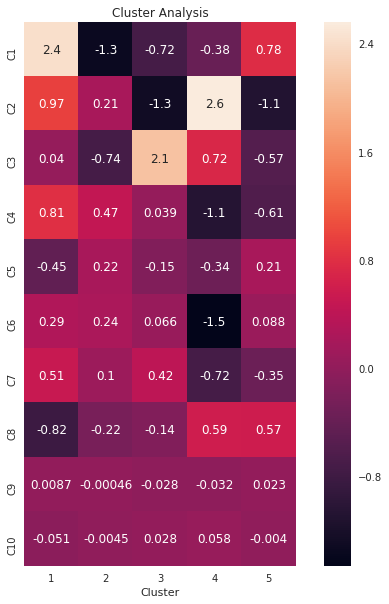

In [38]:
cluster_centers = pd.DataFrame(kmeans.cluster_centers_)
cluster_centers.index += 1
component_labels = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10']
cluster_centers.columns = component_labels

plt.figure(figsize = (10,10))
ax = sns.heatmap(cluster_centers.T, annot=True, square=True)
ax.set_xlabel("Cluster")
ax.set_title("Cluster Analysis")
plt.show()

#### Silhouette Analysis

To determine the optimal number of fire groups, I will use [silhouette analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py) to visualize the separation between the groups. The silhouette coefficient is measure of how close samples in each group are to the group center and to points in the neighboring group. The coefficients range from -1, indicating group misclassification to 1 where clear separation exists between group and a value of 0 means that the sample is close to the boundary between groups. The average silhouette coefficient across all samples is used to assess the quality of clustering with the given number of fire groups.<br><br>
Below is the result of the silhouette analysis. The number of proposed fire groups ranged from 2 to 9 and the average silhouette coefficient peaked at a value of 0.451 using 8 groups. The low values of average silhouette coefficient across the entire range of groups demonstrate that the data is not densely clustered and/or there is significant overlap between groups. For 5, 8, or 9 fire groups, there is some overlap as there are some negative values of the silhouette coefficient.<br><br>
I think the optimal number of fire groups to use for this analysis is 6. The average silhouette score for 6 fire groups was 0.409 which is only 4% less than the maximum average silhouette score calculated in this range. The data was the most evenly distributed amongst 6 fire groups and had no negative silhouette scores which are indications for misclassifications.

For 2 fire groups, the average silhouette_score is : 0.2194286369574898
For 3 fire groups, the average silhouette_score is : 0.3067933620127829
For 4 fire groups, the average silhouette_score is : 0.3329670427944064
For 5 fire groups, the average silhouette_score is : 0.38211635772358926
For 6 fire groups, the average silhouette_score is : 0.4098181681105645
For 7 fire groups, the average silhouette_score is : 0.4396056192052725
For 8 fire groups, the average silhouette_score is : 0.45108553727544226
For 9 fire groups, the average silhouette_score is : 0.43686407098827384


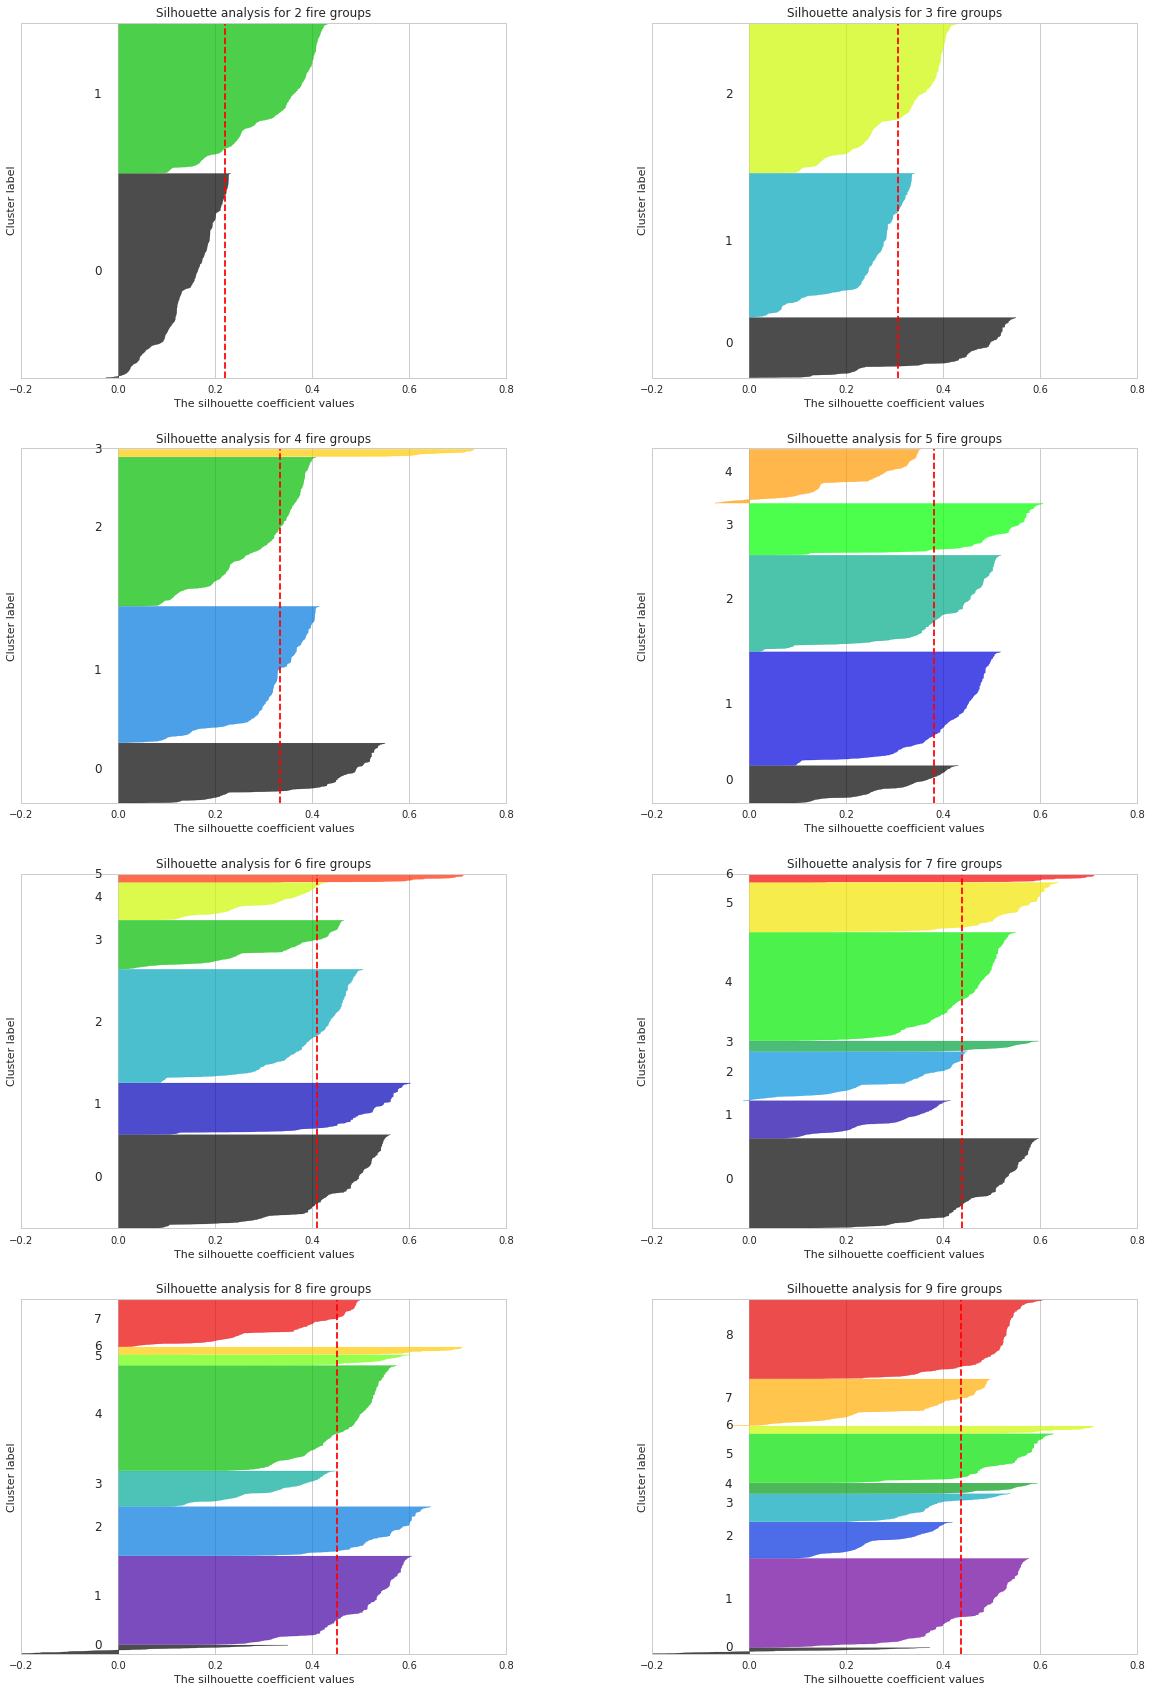

In [39]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
fig = plt.figure(figsize=(20,30))
fig.subplots_adjust(hspace=0.2, wspace=0.3)

for index, n_clusters in enumerate(range_n_clusters, start=1):
    ax = fig.add_subplot(4,2,index)
    ax.set_xlim([-0.2, 0.8])
    ax.set_ylim([0, wildfire_df9.shape[0] + (n_clusters + 1) * 10])

    #Seperate the data based on the number of clusters and calculate the Silhoutte score
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(wildfire_df9)
    silhouette_avg = silhouette_score(wildfire_df9, cluster_labels)
    print("For %d fire groups," % n_clusters,
          "the average silhouette_score is :", silhouette_avg)

    sample_silhouette_values = silhouette_samples(wildfire_df9, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette analysis for %d fire groups" % n_clusters)
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8])

plt.show()

The data was reclassified into six fire groups and compared to the original size class system. The six fire groups more evenly distribute the burned area than the size class system, with no single group accounting for more than half of the reported number of wildfires.

In [40]:
number_of_fire_groups = 6
kmeans = KMeans(n_clusters = number_of_fire_groups, random_state = 0)
kmeans.fit(wildfire_df9)

wildfire_df10 = wildfire_df4.copy()
wildfire_df10['Fire_Group'] = kmeans.labels_.reshape(-1,1) + 1

fire_groups = wildfire_df10.groupby(['Fire_Group'])['current_size'].count().sort_values(ascending=False)
fg_percent = fire_groups / fire_groups.sum()
fg_burned_area = wildfire_df10.groupby(['Fire_Group'])['current_size'].sum().sort_values(ascending=False)
fg_burned_percent = fg_burned_area / fg_burned_area.sum()
fire_group_summary = pd.concat([fire_groups, fg_percent, fg_burned_area, fg_burned_percent],
                          axis=1, keys=['Fire_Group', 'Fire_Group_Percent', 
                                        'Fire_Group_Burned_Area', 'Fire_Group_Burned_Area_Percent'], sort=True)

,Fire_Group,Fire_Group_Percent,Fire_Group_Burned_Area,Fire_Group_Burned_Area_Percent
Fire_Group,,,,
1,295,0.030334,132966.74,0.050981
2,2995,0.307969,983476.57,0.377074
3,1477,0.151877,241170.24,0.092467
4,2558,0.263033,261842.48,0.100393
5,1368,0.140668,549830.26,0.210810
6,1032,0.106118,438891.82,0.168275


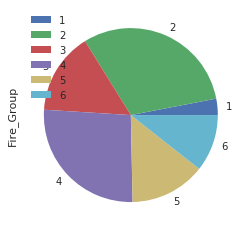

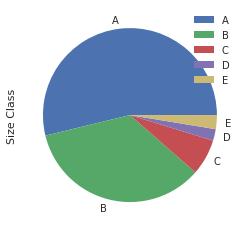

In [41]:
pie1 = fire_group_summary.plot.pie(y='Fire_Group')
pie2 = class_summary.plot.pie(y='Size Class')
fire_group_summary

#### Wildfire Size Prediction

The other objective of the analysis was to use the observed initial state of the fire and the estimated response times to predict the final size of the wildfire once it is extinguished in order to optimize the use of suppression resources. A regression model will be created for each fire group to predict the extinguished size of the wildfires. The fire group classification along with the time duration data between wildfire states will be used as input into the regression models. The data was sorted by the fire group, standardized using a power transform, and then split into 80/20% train/test sets, using k-fold cross validation to avoid overfitting the training data.

In [42]:
size_transformer = PowerTransformer()

wildfire_df11 = pd.DataFrame(size_transformer.fit_transform(wildfire_regression.astype(float)))

wildfire_df11.columns = wildfire_regression.columns
wildfire_df11.index = wildfire_regression.index
wildfire_df11.describe()

,assessment_duration,initial_action_duration,bh_duration,uc_duration,ex_duration,current_size
count,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03,9.725000e+03
mean,-1.693247e-16,-2.169359e-16,-1.302312e-15,1.566308e-15,1.608311e-16,1.895730e-15
std,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00,1.000051e+00
min,-1.821287e+00,-2.465795e+00,-1.083984e+00,-1.344807e+00,-2.191009e+00,-4.427199e-01
25%,-6.385579e-01,-5.031130e-01,-1.083984e+00,-1.344807e+00,-6.946543e-01,-4.427199e-01
50%,8.447436e-02,-7.759110e-02,2.090118e-01,7.950127e-02,-2.085415e-01,-3.837974e-01
75%,5.316389e-01,3.625281e-01,7.265821e-01,7.388814e-01,7.045911e-01,-1.250161e-01
max,4.637665e+00,5.901232e+00,3.241841e+00,2.949873e+00,3.147829e+00,8.716746e+00


In [43]:
from sklearn.model_selection import train_test_split

In [44]:
wildfire_df11['fire_group'] = kmeans.labels_.reshape(-1,1) + 1
wildfire_df12 = wildfire_df11.copy()
wildfire_data=[]
for fg_number in range(1, number_of_fire_groups+1):
    
    is_fg = (wildfire_df12['fire_group'] == fg_number)
    fg_data = wildfire_df12.loc[is_fg]
    fg_y = fg_data['current_size']
    fg_data.drop(['current_size', 'fire_group'], axis=1, inplace=True)
    
    fg_X_train, fg_X_test, fg_y_train, fg_y_test = train_test_split(fg_data, fg_y, test_size=0.2, random_state=10)
                  
    wildfire_data.append([fg_X_train, fg_y_train, fg_X_test,fg_y_test])

/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [45]:
# Loop for checking the contents of the wildfire_data array
for index, fg in enumerate(wildfire_data, start=1):
    print("Fire Group %d:" % index)
    print("Train X-", len(fg[0]))
    print("Train y-", len(fg[1]))
    print("Test X-", len(fg[2]))
    print("Test y-", len(fg[3]))
    print("\n")

Fire Group 1:
Train X- 236
Train y- 236
Test X- 59
Test y- 59


Fire Group 2:
Train X- 2396
Train y- 2396
Test X- 599
Test y- 599


Fire Group 3:
Train X- 1181
Train y- 1181
Test X- 296
Test y- 296


Fire Group 4:
Train X- 2046
Train y- 2046
Test X- 512
Test y- 512


Fire Group 5:
Train X- 1094
Train y- 1094
Test X- 274
Test y- 274


Fire Group 6:
Train X- 825
Train y- 825
Test X- 207
Test y- 207




The first models to be considered are the linear ordinary least squares model, a random forest/decision tree, and a support vector regression machine (SVR). I chose these three models as they are some of the most common regression models. To choose which model to use, I fit a regressor using the default or recommended parameters to each fire groups’ training data and calculate the R2 score and used the average R2 score across all 6 fire groups as a first pass check on which regression model to pursue further.
From the results below, the linear model performs poorly on the data, with an average R2 of 44.6%. The random forest and SVR performed comparatively well, around a R2 value of 77.0% and 73.6% respectively, with the random forest performing more consistently well across the fire groups than the SVR. These two models will be compared again after some hyperparameter tuning.

In [46]:
def Compare_Regression_Model(model_name, estimator):
    print(model_name)
    avg_score = 0
    for num, fire_group in enumerate(wildfire_data, start=1):
        regr = estimator
        regr.fit(fire_group[0], fire_group[1])
        regr_score = regr.score(fire_group[0], fire_group[1])
        avg_score += regr_score
        print("Fire_Group %d: " % num, regr_score)

    avg_score = avg_score / len(wildfire_data)
    print("\nAverage Score:", avg_score)

In [47]:
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor

In [48]:
model_name = "Ordinary Least Squares Linear Regression Trials"
regr = linear_model.LinearRegression()
Compare_Regression_Model(model_name, regr)

Ordinary Least Squares Linear Regression Trials
Fire_Group 1:  0.4485798736633497
Fire_Group 2:  0.49497465136127644
Fire_Group 3:  0.41555823191661273
Fire_Group 4:  0.344885917759165
Fire_Group 5:  0.36319388554882126
Fire_Group 6:  0.6097360969729257

Average Score: 0.44615477620369176


In [49]:
model_name = "Decision Tree Regression Trials"
regr = RandomForestRegressor(n_estimators = 10, max_depth = 3, min_samples_leaf=5, 
                                 max_features = None, random_state=10)
Compare_Regression_Model(model_name, regr)

Decision Tree Regression Trials
Fire_Group 1:  0.7485069821350275
Fire_Group 2:  0.7886214984061131
Fire_Group 3:  0.7569873885246399
Fire_Group 4:  0.7274896087882121
Fire_Group 5:  0.7621764495660367
Fire_Group 6:  0.8368440505984837

Average Score: 0.7701043296697522


In [50]:
model_name = "Support Vector Regression Trials"
regr = svm.SVR(kernel='rbf', gamma='scale', C=1.0)
Compare_Regression_Model(model_name, regr)

Support Vector Regression Trials
Fire_Group 1:  0.6265638772749853
Fire_Group 2:  0.8030957636572011
Fire_Group 3:  0.7144718997943746
Fire_Group 4:  0.7028356962960411
Fire_Group 5:  0.7346229966095776
Fire_Group 6:  0.8368227840119741

Average Score: 0.7364021696073589


### Refinement

The optimization was completed using random parameter search to optimize the regressors as per the process detailed [here](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74). The hyperparameters of both models were varied over a wide range and cross-validated 3 times over the testing data for each fire group. Again, I am using the average R2 score as measure of performance to compare both models. The results of the tuning resulted in approximately 10% increase in R2 value in both models, with the random forest performing slightly better. For this reason, I will use the random forest model to predict the final size of wildfires.

In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error

In [52]:
def Optimize_Regression_Model(model_name, estimator_optimizier):
    print(model_name)
    avg_score = 0
    best_regrs = []
    for num, fire_group in enumerate(wildfire_data, start=1):
        regr_optimizer = estimator_optimizier
        regr_optimizer.fit(fire_group[0], fire_group[1])
        best_regr = regr_optimizer.best_estimator_
        best_regrs.append(best_regr)
        regr_score = best_regr.score(fire_group[0], fire_group[1])
        avg_score += regr_score
        print("Fire_Group %d Best R2: " % num, regr_score)

    avg_score = avg_score / len(wildfire_data)
    print("\nAverage Score:", avg_score)
    return best_regrs

In [53]:
n_estimators = [int(x) for x in np.linspace(50,1000,20)]
max_depth = [int(x) for x in np.linspace(3,10,5)]
min_samples_split = [2,5]
min_samples_leaf = [int(x) for x in np.linspace(1,10,5)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

random_forest = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = random_forest, param_distributions = random_grid, n_iter = 100, cv=3, random_state=10)

In [55]:
best_forests = Optimize_Regression_Model("Random Forest Regression Model", rf_random)

Random Forest Regression Model


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fire_Group 1 Best R2:  0.8557933785265879
Fire_Group 2 Best R2:  0.9157191497549494
Fire_Group 3 Best R2:  0.8831992976817924
Fire_Group 4 Best R2:  0.8242526103613299
Fire_Group 5 Best R2:  0.9026492042097306
Fire_Group 6 Best R2:  0.9347557363062217

Average Score: 0.8860615628067685


In [56]:
n_estimators = [int(x) for x in np.linspace(2,100,20)]
C_values = [x for x in np.linspace(1,10,50)]
gamma = ['scale', 'auto']

random_grid = {'C': C_values,
               'gamma': gamma}

SVR_regr = svm.SVR()
SVR_rand = RandomizedSearchCV(estimator = SVR_regr, param_distributions = random_grid, n_iter = 100, cv=3, random_state=10)

In [57]:
best_svr = Optimize_Regression_Model("SVR Regression Model", SVR_rand)

SVR Regression Model


/home/ec2-user/anaconda3/envs/amazonei_mxnet_p36/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Fire_Group 1 Best R2:  0.9174588501935982
Fire_Group 2 Best R2:  0.8353842325098082
Fire_Group 3 Best R2:  0.7954120330849319
Fire_Group 4 Best R2:  0.7968554054820343
Fire_Group 5 Best R2:  0.8631311464435374
Fire_Group 6 Best R2:  0.8943929024161903

Average Score: 0.8504390950216835


The root mean square error is also calculated to quantify the accuracy of the regression model. The RMSE was calculated to be 0.552 or 55.2% of the standard variation of the transformed input data, which is relatively high. To make sense of the actual wildfire size predictions, the inverse transform was used to restore the data to the true scale. The calculated RMSE between all the predicted sizes and the current sizes, regardless of fire group, was calculated to be 7,338 Ha which is high. The mean, median, and maximum values between the predicted and current sizes are also quite different. This may indicate that the regression is not a good predictor of wildfire sizes.

In [58]:
def Evaluate_Regression_Models(model_name, estimators):
    print(model_name)
    avg_error = 0
    avg_r2 = 0
    for num, estimator in enumerate(estimators, start=0):
        y_pred = estimator.predict(wildfire_data[num][2])
        y_true = wildfire_data[num][3]
        rmse = np.sqrt(mean_squared_error(y_true = y_true, y_pred = y_pred))
        regr_score = estimator.score(wildfire_data[num][2], y_true)
        avg_error += rmse
        avg_r2 += regr_score
        print("Fire_Group %d: " % (num+1), rmse)

    avg_error = avg_error / len(estimators)
    print("\nAverage RMSE:", avg_error)
    print("\nAverage R2:", avg_r2)

In [59]:
Evaluate_Regression_Models("Random Forest Regression Model RMSE", best_forests)

Random Forest Regression Model RMSE
Fire_Group 1:  0.7719679354586958
Fire_Group 2:  0.469223917176183
Fire_Group 3:  0.6456385939307302
Fire_Group 4:  0.42963185183040925
Fire_Group 5:  0.3997678145164133
Fire_Group 6:  0.5953597104075965

Average RMSE: 0.5519316372200047

Average R2: 4.21979370379677


In [60]:
def Wildfire_Size_Predictions(estimators, df):
    transformed_df = df.copy()
    transformed_df['predicted_size'] = 0.0
    for num, estimator in enumerate(estimators, start=0):
        is_fg = (transformed_df['fire_group'] == (num+1))
        fire_df = transformed_df.loc[is_fg].drop(['current_size', 'fire_group', 'predicted_size'], axis=1)
        predicted_sizes = estimator.predict(fire_df)
        transformed_df.loc[is_fg,'predicted_size'] = predicted_sizes
    return transformed_df

In [61]:
wildfire_df13 = Wildfire_Size_Predictions(best_forests, wildfire_df11)
wildfire_df13.drop(['fire_group', 'current_size'], axis=1, inplace=True)
wildfire_df14 = pd.DataFrame(size_transformer.inverse_transform(wildfire_df13))
wildfire_df14.columns = wildfire_df13.columns
wildfire_df14.index = wildfire_df13.index
wildfire_df14['current_size'] = wildfire_regression['current_size']
wildfire_df14['fire_group'] = wildfire_df11['fire_group']
wildfire_df14['predicted_size'] = round(wildfire_df14['predicted_size'],2)
wildfire_df14.describe()

,assessment_duration,initial_action_duration,bh_duration,uc_duration,ex_duration,predicted_size,current_size,fire_group
count,9725.000000,9.725000e+03,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000,9725.000000
mean,112.877018,4.847354e+02,326.360514,1137.167711,4548.542722,68.993034,268.193122,3.494087
std,672.205447,9.810525e+03,1839.738479,6208.361816,25332.557770,970.877226,8014.137007,1.402197
min,0.000000,-4.440892e-16,0.000000,0.000000,0.000000,0.020000,0.010000,1.000000
25%,6.000000,2.100000e+01,0.000000,0.000000,40.000000,0.090000,0.010000,2.000000
50%,22.000000,4.200000e+01,26.000005,54.999998,135.999999,0.220000,0.100000,4.000000
75%,47.000000,8.500000e+01,100.000005,360.000000,1319.999987,0.640000,0.600000,4.000000
max,41221.000067,5.282330e+05,61480.988932,186751.010157,567865.002221,51237.570000,577646.800000,6.000000


In [62]:
predicted_size = wildfire_df14['predicted_size']
current_size = wildfire_df14['current_size']
RMSE = np.sqrt(mean_squared_error(y_true = current_size, y_pred = predicted_size))
print('Root mean square error: ', RMSE)
print('Median predicted wildfire size: ', predicted_size.median())
print('Median current wildfire size: ', current_size.median())

Root mean square error:  7338.2358643912985
Median predicted wildfire size:  0.22
Median current wildfire size:  0.1


## Conclusion

The wildfire data collected by the Alberta Government between 2006 and 2017 was analyzed to create distinct fire groups and used to create regression models to predict the final burned area of wildfires. The fire groups consisted of wildfires with similar initial conditions and detection/suppression resources. The regression models for each fire group used the estimated time between wildfire stages to predict the final size of the wildfire. The intent behind these predictors is that new fires would be put into the appropriate fire groups and suppression resources can be scheduled based on how long the wildfire exists in the wildfire lifecycle stage. For example, an air patrol could discover a wildfire that is defined as a fire group 1 fire. Based on their current resources, an estimated time to get control of the fire and change the state from UC to BH could be used to determine if additional resources are required.<br><br>
Below are various plots showing the comparison of the predicted wildfire sizes to the actual final sizes of the wildfires for each fire group and the distribution of the data within the fire groups. The scatter plots display the log transform of the data to show more detail of the distribution due to the presence of outliers in the data. The relationship between the predicted and actual wildfire sizes is approximately linear but contains a lot of noise, especially in the smaller sizes.<br><br>
The pie plot shows the optimized distribution of fire groups in the data, using the assessed conditions of the wildfires. The wildfire data was more evenly distributed amongst the fire groups compared to the size class. This implies that there are many similarities between the wildfire assessed conditions and the distinguishing features used to define the fire groups such as the initial suppression/detection resources, assessment size, and fire type define the boundaries between fire groups. The low silhouette scores for each group also indicated that there is little separation between the fire groups.

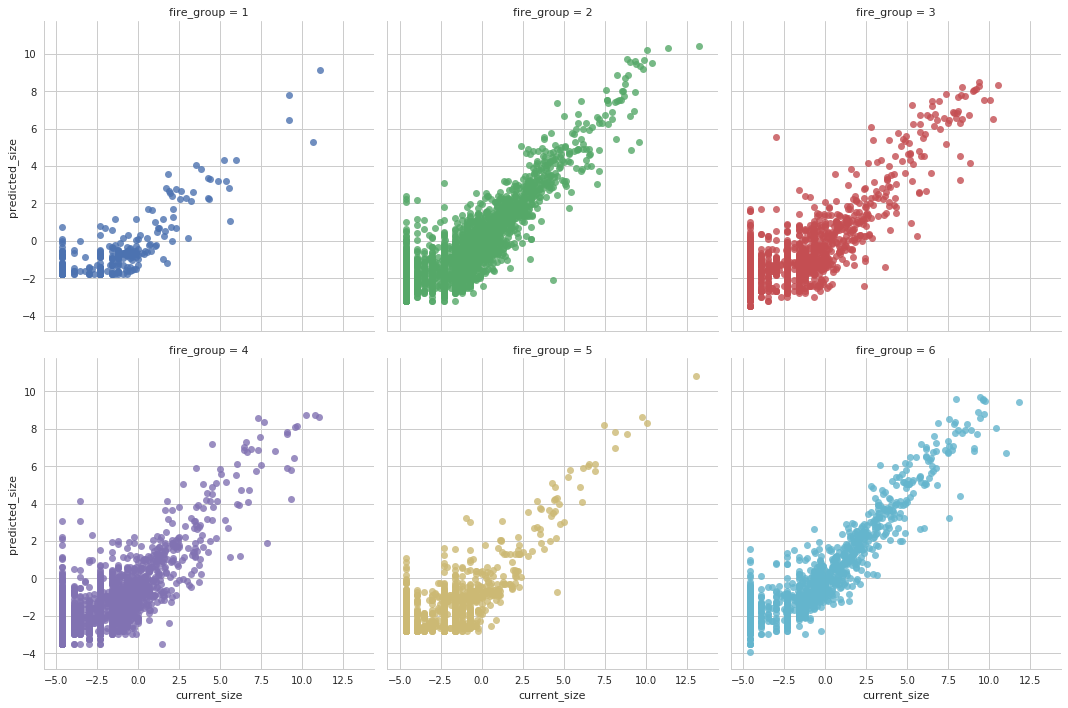

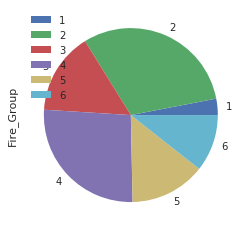

In [63]:
wildfires = pd.concat([np.log(current_size), np.log(predicted_size), wildfire_df14['fire_group']], axis=1)
plt = sns.lmplot(x='current_size', y='predicted_size', col='fire_group', fit_reg=False, hue='fire_group', data=wildfires, col_wrap=3)
pie = fire_group_summary.plot.pie(y='Fire_Group')

### Reflection and Improvements

The original intent of the analysis was to use the assessed conditions of wildfires to identify distinguishing features used to create specific fire groups. However, the data provided was quite skewed and concentrated in few categories, like the fuel type, weather conditions, fire slope, fire type, and because of this the principle components that make up the fire groups were defined by few distinguishing features so there was no clear separation between the fire groups. More details in the fire assessments could provide more features to be used to further define the fire groups. Also, separating the physical properties of the wildfires from the utilized suppression resources to create more explainable classifications could have improved the analysis. In this case, the fire group, detection agent type, and initial action resource would be used in another layer of classification or as additional inputs in the regression analysis.<br><br>
The regression analysis accuracy was calculated to be 89%, approximately equal to the target accuracy of 90%. Despite this, the RMSE was high and there was still a lot of spread in the predicted wildfire sizes. More optimization of the hyper-parameters used in the regression could improve the results, but I think reducing the number of inputs would have a larger effect. Instead of using the time between each wildfire lifecycle stage, maybe using the time between wildfire detection and when it is under control would give more accurate predictions. Another option is to remove the outliers in the size data corresponding to the largest wildfires and only predict wildfire sizes of moderate sizes instead of predicting all wildfire sizes. The regression would probably more closely predict the wildfire sizes and could be used to identify if a given fire would become an outlier with the estimated response times.
